PyTorch version: 2.1.2+cu118
CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla P100-PCIE-12GB
Loading dataset: Al-Mg-Si-XCT
Image directory: ./Al-Mg-Si-XCT/images
Mask directory: ./Al-Mg-Si-XCT/masks
Found 150 valid image-mask pairs
Loading dataset: AFM
Image directory: ./AFM/images
Mask directory: ./AFM/masks
Found 46 valid image-mask pairs
Loading dataset: Bond-Wire-XCT
Image directory: ./Bond-Wire-XCT/images
Mask directory: ./Bond-Wire-XCT/masks
Found 0 valid image-mask pairs
Loading dataset: Carbon
Image directory: ./Carbon/images
Mask directory: ./Carbon/masks
Found 0 valid image-mask pairs
Loading dataset: Fractography
Image directory: ./Fractography/images
Mask directory: ./Fractography/masks
Found 0 valid image-mask pairs

Dataset Summary:
Al-Mg-Si-XCT: 150 image-mask pairs
AFM: 46 image-mask pairs
Bond-Wire-XCT: 0 image-mask pairs
Carbon: 0 image-mask pairs
Fractography: 0 image-mask pairs
Testing MicroNet model loading...
Successfully loaded MicroNet w

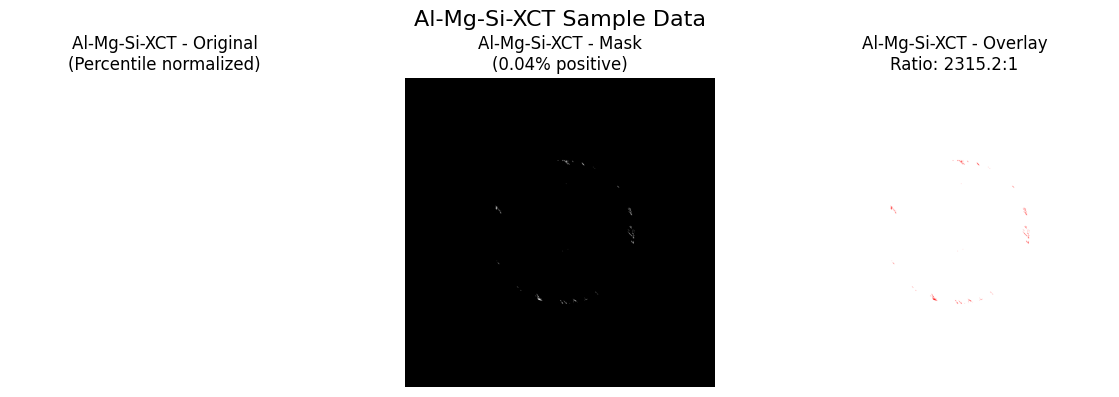


Starting Al-Mg-Si-XCT experiment...
MDSMG: Material Data Science Model Garden
Al-Mg-Si-XCT Dataset Experiment
Starting Al-Mg-Si-XCT experiment...
Starting MDSMG Al-Mg-Si-XCT Experiment on cuda
Total experiments to run: 12
Running experiment 1/12: resnet50_unet_imagenet
EXPERIMENT: Al-Mg-Si-XCT | resnet50 | unet | imagenet
Loading dataset: Al-Mg-Si-XCT
Image directory: ./Al-Mg-Si-XCT/images
Mask directory: ./Al-Mg-Si-XCT/masks
Found 150 valid image-mask pairs
Dataset split: 120 train, 30 validation
Creating encoder: resnet50 with imagenet pretraining
✓ ResNet50 with ImageNet weights loaded
Training resnet50_unet_imagenet for 200 epochs on cuda
Using Focal Loss for class imbalance
------------------------------------------------------------


Epoch 1/200: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s, train_loss=0.0197]


Epoch   1: Train Loss: 0.0324 | Val Loss: 0.0208 | Val IoU: 0.0000 | Val Dice: 0.0000
  New best IoU: 0.0000


Epoch 3/200:  33%|███▎      | 20/60 [00:14<00:28,  1.42it/s, train_loss=0.0103]


KeyboardInterrupt: 

In [1]:
# Material Data Science Model Garden (MDSMG) Experiment
# Systematic Evaluation of Encoder-Decoder Architectures for Material Image Segmentation
# Al-Mg-Si-XCT Dataset Experiment

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
import segmentation_models_pytorch as smp
from huggingface_hub import hf_hub_download
import timm

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name())

class MaterialDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, image_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.image_size = image_size
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Load image with proper handling for different bit depths
        if image_path.endswith('.tif') or image_path.endswith('.tiff'):
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            # Handle different bit depths (uint16, uint8, etc.)
            if image.dtype == np.uint16:
                # Use percentile-based normalization for better contrast
                p1, p99 = np.percentile(image, (1, 99))
                image = np.clip((image - p1) / (p99 - p1) * 255, 0, 255).astype(np.uint8)
            elif image.dtype != np.uint8:
                image = image.astype(np.uint8)
                
        else:
            image = np.array(Image.open(image_path).convert('RGB'))
            
        # Load mask with proper handling
        if mask_path.endswith('.tif') or mask_path.endswith('.tiff'):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Handle different mask bit depths
            if mask.dtype == np.uint16:
                mask_max = mask.max()
                if mask_max > 255:
                    mask = (mask.astype(np.float32) / mask_max * 255.0).astype(np.uint8)
                else:
                    mask = mask.astype(np.uint8)
            elif mask.dtype != np.uint8:
                mask = mask.astype(np.uint8)
        else:
            mask = np.array(Image.open(mask_path).convert('L'))
        
        # Resize images
        image = cv2.resize(image, self.image_size)
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
        
        # More careful mask binarization
        unique_vals = np.unique(mask)
        
        # Create binary mask
        if len(unique_vals) == 2 and 0 in unique_vals:
            mask = (mask > 0).astype(np.uint8)
        else:
            threshold = np.percentile(mask[mask > 0], 50) if np.any(mask > 0) else 127
            mask = (mask > threshold).astype(np.uint8)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            # Convert to float32 before creating tensor
            image = image.astype(np.float32)
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            mask = torch.from_numpy(mask.astype(np.float32)).float()
            
        return image, mask

def load_dataset_paths(base_path, dataset_name):
    dataset_path = os.path.join(base_path, dataset_name)
    image_dir = os.path.join(dataset_path, 'images')
    mask_dir = os.path.join(dataset_path, 'masks')
    
    print(f"Loading dataset: {dataset_name}")
    print(f"Image directory: {image_dir}")
    print(f"Mask directory: {mask_dir}")
    
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        print(f"Warning: Directory does not exist for {dataset_name}")
        return [], []
    
    image_extensions = ['*.png', '*.tif', '*.tiff', '*.jpg', '*.jpeg']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(image_dir, ext)))
    
    mask_paths = []
    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        img_name_no_ext = os.path.splitext(img_name)[0]
        
        for mask_ext in ['png', 'tif', 'tiff']:
            mask_path = os.path.join(mask_dir, f"{img_name_no_ext}.{mask_ext}")
            if os.path.exists(mask_path):
                mask_paths.append(mask_path)
                break
    
    valid_pairs = []
    valid_mask_paths = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_pairs.append(img_path)
            valid_mask_paths.append(mask_path)
    
    print(f"Found {len(valid_pairs)} valid image-mask pairs")
    return valid_pairs, valid_mask_paths

base_path = "."
datasets = ['Al-Mg-Si-XCT', 'AFM', 'Bond-Wire-XCT', 'Carbon', 'Fractography']

dataset_info = {}
for dataset_name in datasets:
    image_paths, mask_paths = load_dataset_paths(base_path, dataset_name)
    dataset_info[dataset_name] = len(image_paths)
    
print("\nDataset Summary:")
for name, count in dataset_info.items():
    print(f"{name}: {count} image-mask pairs")

def load_micronet_weights(model_name='micronet-resnet50'):
    try:
        if model_name == 'micronet-resnet50':
            filenames_to_try = [
                "resnet50_micronet_weights.pth",
                "resnet50_imagenet-micronet_weights.pth", 
                "pytorch_model.bin"
            ]
            repo_id = "jstuckner/microscopy-resnet50-micronet"
            
        elif model_name == 'micronet-se_resnext101':
            filenames_to_try = [
                "resnext101_micronet_weights.pth",
                "resnext101_imagenet-micronet_weights.pth",
                "pytorch_model.bin"
            ]
            repo_id = "jstuckner/microscopy-resnext101-micronet"
        else:
            raise ValueError(f"Unknown MicroNet model: {model_name}")
        
        weights = None
        for filename in filenames_to_try:
            try:
                model_path = hf_hub_download(repo_id=repo_id, filename=filename)
                weights = torch.load(model_path, map_location='cpu')
                print(f"Successfully loaded MicroNet weights for {model_name} from {filename}")
                break
            except Exception as e:
                print(f"Failed to load {filename}: {str(e)}")
                continue
        
        if weights is None:
            print(f"Failed to load any weights for {model_name}")
            
        return weights
    
    except Exception as e:
        print(f"Failed to load MicroNet weights for {model_name}: {str(e)}")
        return None

print("Testing MicroNet model loading...")
micronet_resnet50_weights = load_micronet_weights('micronet-resnet50')
micronet_se_resnext101_weights = load_micronet_weights('micronet-se_resnext101')

if micronet_resnet50_weights:
    print("✓ MicroNet ResNet50 weights loaded successfully")
    print(f"  Keys in state dict: {len(micronet_resnet50_weights.keys())}")
    
if micronet_se_resnext101_weights:
    print("✓ MicroNet SE-ResNeXt101 weights loaded successfully")
    print(f"  Keys in state dict: {len(micronet_se_resnext101_weights.keys())}")

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

def create_encoder(encoder_name='resnet50', pretrained='imagenet'):
    print(f"Creating encoder: {encoder_name} with {pretrained} pretraining")
    
    if encoder_name == 'resnet50':
        if pretrained == 'imagenet':
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights='imagenet')
            print("✓ ResNet50 with ImageNet weights loaded")
        elif pretrained == 'micronet':
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights=None)
            micronet_weights = load_micronet_weights('micronet-resnet50')
            if micronet_weights:
                try:
                    encoder.load_state_dict(micronet_weights, strict=False)
                    print("✓ ResNet50 with MicroNet weights loaded")
                except Exception as e:
                    print(f"⚠ Failed to load MicroNet weights strictly, trying partial loading: {str(e)}")
                    model_dict = encoder.state_dict()
                    pretrained_dict = {k: v for k, v in micronet_weights.items() 
                                     if k in model_dict and v.shape == model_dict[k].shape}
                    model_dict.update(pretrained_dict)
                    encoder.load_state_dict(model_dict)
                    print(f"✓ ResNet50 with partial MicroNet weights loaded ({len(pretrained_dict)} layers)")
            else:
                print("⚠ Failed to load MicroNet weights, using random initialization")
        else:
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights=None)
            print("✓ ResNet50 with random weights")
            
        encoder_channels = [3, 64, 256, 512, 1024, 2048]
    
    elif encoder_name == 'se_resnext101':
        if pretrained == 'imagenet':
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights='imagenet')
            print("✓ SE-ResNeXt101 with ImageNet weights loaded")
        elif pretrained == 'micronet':
            print("⚠ MicroNet weights for SE-ResNeXt101 have architecture mismatch")
            print("  Using ImageNet pretrained weights as fallback")
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights='imagenet')
            
            micronet_weights = load_micronet_weights('micronet-se_resnext101')
            if micronet_weights:
                try:
                    model_dict = encoder.state_dict()
                    pretrained_dict = {}
                    for k, v in micronet_weights.items():
                        if k in model_dict and v.shape == model_dict[k].shape:
                            pretrained_dict[k] = v
                    
                    if len(pretrained_dict) > 0:
                        model_dict.update(pretrained_dict)
                        encoder.load_state_dict(model_dict)
                        print(f"✓ Loaded {len(pretrained_dict)} compatible layers from MicroNet")
                    else:
                        print("✗ No compatible layers found in MicroNet weights")
                        
                except Exception as e:
                    print(f"✗ Failed to load any MicroNet weights: {str(e)}")
            
        else:
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights=None)
            print("✓ SE-ResNeXt101 with random weights")
            
        encoder_channels = [3, 64, 256, 512, 1024, 2048]
    
    return encoder, encoder_channels

class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, n_classes=1):
        super(UNetDecoder, self).__init__()
        
        self.decoder_blocks = nn.ModuleList()
        
        for i in range(len(decoder_channels)):
            if i == 0:
                in_ch = encoder_channels[-1]
            else:
                in_ch = decoder_channels[i-1]
            
            out_ch = decoder_channels[i]
            skip_ch = encoder_channels[-(i+2)] if i < len(encoder_channels)-1 else 0
            
            block = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
                nn.Conv2d(out_ch + skip_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
            
            self.decoder_blocks.append(block)
        
        self.final_conv = nn.Conv2d(decoder_channels[-1], n_classes, kernel_size=1)
        
    def forward(self, encoder_features):
        x = encoder_features[-1]
        
        for i, decoder_block in enumerate(self.decoder_blocks):
            x = decoder_block[0](x)
            
            if i < len(encoder_features) - 1:
                skip = encoder_features[-(i+2)]
                if x.shape[2:] != skip.shape[2:]:
                    x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
                x = torch.cat([x, skip], dim=1)
            
            for layer in decoder_block[1:]:
                x = layer(x)
        
        return self.final_conv(x)

class ASPPModule(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPPModule, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.atrous_convs = nn.ModuleList()
        for rate in atrous_rates:
            self.atrous_convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.project = nn.Sequential(
            nn.Conv2d(out_channels * (2 + len(atrous_rates)), out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        
    def forward(self, x):
        h, w = x.shape[2:]
        
        feat1 = self.conv1(x)
        atrous_feats = [conv(x) for conv in self.atrous_convs]
        global_feat = self.global_pool(x)
        global_feat = F.interpolate(global_feat, size=(h, w), mode='bilinear', align_corners=False)
        
        concat_feat = torch.cat([feat1] + atrous_feats + [global_feat], dim=1)
        return self.project(concat_feat)

class DeepLabV3Decoder(nn.Module):
    def __init__(self, encoder_channels, n_classes=1):
        super(DeepLabV3Decoder, self).__init__()
        self.aspp = ASPPModule(encoder_channels[-1], 256, [6, 12, 18])
        self.classifier = nn.Conv2d(256, n_classes, 1)
        
    def forward(self, encoder_features):
        x = encoder_features[-1]
        x = self.aspp(x)
        x = self.classifier(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

class DeepLabV3PlusDecoder(nn.Module):
    def __init__(self, encoder_channels, n_classes=1):
        super(DeepLabV3PlusDecoder, self).__init__()
        
        self.aspp = ASPPModule(encoder_channels[-1], 256, [6, 12, 18])
        low_level_channels = encoder_channels[1]
        
        self.low_level_proj = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256 + 48, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Conv2d(256, n_classes, 1)
        
    def forward(self, encoder_features):
        low_level = encoder_features[1]
        high_level = encoder_features[-1]
        
        high_level = self.aspp(high_level)
        high_level = F.interpolate(high_level, size=low_level.shape[2:], mode='bilinear', align_corners=False)
        
        low_level = self.low_level_proj(low_level)
        
        concat_feat = torch.cat([high_level, low_level], dim=1)
        decoded = self.decoder(concat_feat)
        output = self.classifier(decoded)
        
        output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
        
        return output

class MaterialSegmentationModel(nn.Module):
    def __init__(self, encoder_name='resnet50', decoder_name='unet', pretrained='imagenet', n_classes=1):
        super(MaterialSegmentationModel, self).__init__()
        
        self.encoder, encoder_channels = create_encoder(encoder_name, pretrained)
        
        if decoder_name == 'unet':
            self.decoder = UNetDecoder(encoder_channels[1:], [256, 128, 64, 32], n_classes)
        elif decoder_name == 'deeplabv3':
            self.decoder = DeepLabV3Decoder(encoder_channels[1:], n_classes)
        elif decoder_name == 'deeplabv3plus':
            self.decoder = DeepLabV3PlusDecoder(encoder_channels, n_classes)
        
        self.config = f"{encoder_name}_{decoder_name}_{pretrained}"
        
    def forward(self, x):
        encoder_features = self.encoder(x)
        
        if hasattr(self.decoder, '__class__') and self.decoder.__class__.__name__ == 'DeepLabV3PlusDecoder':
            output = self.decoder(encoder_features)
        else:
            output = self.decoder(encoder_features[1:])
        
        return output

# Weighted BCE Loss for class imbalance
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=10.0):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        
    def forward(self, inputs, targets):
        # Calculate dynamic positive weight based on class distribution
        pos_pixels = targets.sum()
        neg_pixels = (targets.numel() - pos_pixels)
        
        if pos_pixels > 0:
            dynamic_pos_weight = (neg_pixels / pos_pixels).clamp(min=1.0, max=50.0)
        else:
            dynamic_pos_weight = torch.tensor(self.pos_weight)
            
        return F.binary_cross_entropy_with_logits(inputs, targets, 
                                                pos_weight=dynamic_pos_weight)

# Focal Loss for extreme class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    # Ensure both tensors have same shape
    if target.dim() == 3 and pred.dim() == 4:
        target = target.unsqueeze(1)
    elif target.dim() == 4 and pred.dim() == 3:
        pred = pred.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    # Ensure both tensors have same shape
    if target.dim() == 3 and pred.dim() == 4:
        target = target.unsqueeze(1)
    elif target.dim() == 4 and pred.dim() == 3:
        pred = pred.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def train_model(model, train_loader, val_loader, num_epochs=100, device='cuda'):
    model = model.to(device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    # Use Focal Loss for extreme class imbalance
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=False)
    
    best_val_iou = 0
    history = {
        'train_losses': [],
        'val_losses': [],
        'val_ious': [],
        'val_dices': []
    }
    
    print(f"Training {model.config} for {num_epochs} epochs on {device}")
    print(f"Using Focal Loss for class imbalance")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            
            if outputs.shape[2:] != masks.shape[1:]:
                outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            pbar.set_postfix({'train_loss': f'{loss.item():.4f}'})
            
            if train_batches % 10 == 0:
                torch.cuda.empty_cache()
        
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_batches = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).float()
                
                outputs = model(images)
                if outputs.shape[2:] != masks.shape[1:]:
                    outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
                
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                
                # Ensure consistent dimensions for metrics
                if masks.dim() == 3:
                    masks_for_metrics = masks.unsqueeze(1)
                else:
                    masks_for_metrics = masks
                
                if outputs.dim() == 3:
                    outputs_for_metrics = outputs.unsqueeze(1)
                else:
                    outputs_for_metrics = outputs
                
                val_iou += iou_score(outputs_for_metrics, masks_for_metrics).item()
                val_dice += dice_coefficient(outputs_for_metrics, masks_for_metrics).item()
                val_batches += 1
        
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches
        avg_val_iou = val_iou / val_batches
        avg_val_dice = val_dice / val_batches
        
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['val_ious'].append(avg_val_iou)
        history['val_dices'].append(avg_val_dice)
        
        scheduler.step(avg_val_loss)
        
        if epoch % 10 == 0 or epoch >= num_epochs - 5:
            print(f'Epoch {epoch+1:3d}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f} | Val Dice: {avg_val_dice:.4f}')
        
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), f'best_{model.config}.pth')
            if epoch % 10 == 0 or epoch >= num_epochs - 5:
                print(f'  New best IoU: {best_val_iou:.4f}')
        
        torch.cuda.empty_cache()
    
    history['best_val_iou'] = best_val_iou
    print(f"Training completed! Best validation IoU: {best_val_iou:.4f}")
    return history

def run_single_experiment(dataset_name, encoder_name, decoder_name, pretrained, device='cuda'):
    print(f"EXPERIMENT: {dataset_name} | {encoder_name} | {decoder_name} | {pretrained}")
    print("="*80)
    
    image_paths, mask_paths = load_dataset_paths(".", dataset_name)
    
    if len(image_paths) < 4:
        print(f"Insufficient data for {dataset_name}: {len(image_paths)} samples")
        return None, None
    
    train_images, val_images, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )
    
    print(f"Dataset split: {len(train_images)} train, {len(val_images)} validation")
    
    train_dataset = MaterialDataset(train_images, train_masks, image_size=(256, 256))
    val_dataset = MaterialDataset(val_images, val_masks, image_size=(256, 256))
    
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
    
    model = MaterialSegmentationModel(encoder_name, decoder_name, pretrained, n_classes=1)
    
    history = train_model(model, train_loader, val_loader, num_epochs=200, device=device)
    
    result = {
        'dataset': dataset_name,
        'encoder': encoder_name,
        'decoder': decoder_name,
        'pretrained': pretrained,
        'config': f"{encoder_name}_{decoder_name}_{pretrained}",
        'train_samples': len(train_images),
        'val_samples': len(val_images),
        'best_val_iou': history['best_val_iou'],
        'final_val_dice': history['val_dices'][-1],
        'final_train_loss': history['train_losses'][-1],
        'final_val_loss': history['val_losses'][-1]
    }
    
    print(f"RESULTS: IoU={result['best_val_iou']:.4f} | Dice={result['final_val_dice']:.4f}")
    
    return result, history

def run_almgsi_experiment():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Starting MDSMG Al-Mg-Si-XCT Experiment on {device}")
    
    datasets = ['Al-Mg-Si-XCT']
    encoders = ['resnet50', 'se_resnext101']
    decoders = ['unet', 'deeplabv3', 'deeplabv3plus']
    pretrained_options = ['imagenet', 'micronet']
    
    results = []
    histories = {}
    experiment_count = 0
    
    total_experiments = len(datasets) * len(encoders) * len(decoders) * len(pretrained_options)
    print(f"Total experiments to run: {total_experiments}")
    
    for dataset_name in datasets:
        for encoder in encoders:
            for decoder in decoders:
                for pretrained in pretrained_options:
                    experiment_count += 1
                    
                    print(f"Running experiment {experiment_count}/{total_experiments}: {encoder}_{decoder}_{pretrained}")
                    
                    result, history = run_single_experiment(
                        dataset_name, encoder, decoder, pretrained, device
                    )
                    
                    if result and history:
                        results.append(result)
                        histories[result['config'] + '_' + dataset_name] = history
                        print(f"Experiment {experiment_count}/{total_experiments} completed: {result['config']}")
                    else:
                        print(f"Experiment {experiment_count}/{total_experiments} failed or skipped")
    
    if results:
        results_df = pd.DataFrame(results)
        results_df.to_csv('almgsi_experiment_results.csv', index=False)
        
        print(f"Al-Mg-Si-XCT experiment suite completed!")
        print(f"Total successful experiments: {len(results)}")
        print(f"Results saved to: almgsi_experiment_results.csv")
        
        return results_df, histories
    else:
        print("No successful experiments completed")
        return pd.DataFrame(), {}

def analyze_almgsi_results(results_df):
    print("AL-MG-SI-XCT EXPERIMENT RESULTS ANALYSIS")
    print("="*60)
    
    print(f"Total experiments: {len(results_df)}")
    print(f"Mean IoU across all experiments: {results_df['best_val_iou'].mean():.4f}")
    print(f"Best overall IoU: {results_df['best_val_iou'].max():.4f}")
    
    print("\nPERFORMANCE BY ENCODER:")
    encoder_performance = results_df.groupby('encoder')['best_val_iou'].agg(['mean', 'std', 'max', 'count'])
    encoder_performance.columns = ['Mean_IoU', 'Std_IoU', 'Max_IoU', 'Count']
    print(encoder_performance.round(4))
    
    print("\nPERFORMANCE BY DECODER:")
    decoder_performance = results_df.groupby('decoder')['best_val_iou'].agg(['mean', 'std', 'max', 'count'])
    decoder_performance.columns = ['Mean_IoU', 'Std_IoU', 'Max_IoU', 'Count']
    print(decoder_performance.round(4))
    
    print("\nPERFORMANCE BY PRETRAINING:")
    pretrained_performance = results_df.groupby('pretrained')['best_val_iou'].agg(['mean', 'std', 'max', 'count'])
    pretrained_performance.columns = ['Mean_IoU', 'Std_IoU', 'Max_IoU', 'Count']
    print(pretrained_performance.round(4))
    
    best_idx = results_df['best_val_iou'].idxmax()
    best_config = results_df.loc[best_idx]
    print(f"\nBEST CONFIGURATION:")
    print(f"Config: {best_config['config']}")
    print(f"IoU: {best_config['best_val_iou']:.4f}")
    print(f"Dice: {best_config['final_val_dice']:.4f}")
    
    return encoder_performance, decoder_performance, pretrained_performance

def statistical_analysis_almgsi(results_df):
    print("STATISTICAL ANALYSIS")
    print("="*50)
    
    resnet50_ious = results_df[results_df['encoder'] == 'resnet50']['best_val_iou']
    se_resnext_ious = results_df[results_df['encoder'] == 'se_resnext101']['best_val_iou']
    
    if len(resnet50_ious) > 0 and len(se_resnext_ious) > 0:
        t_stat, p_val = stats.ttest_ind(resnet50_ious, se_resnext_ious)
        print(f"Encoder comparison (ResNet50 vs SE-ResNeXt101):")
        print(f"  t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
        if p_val < 0.05:
            print(f"  Significant difference (p < 0.05)")
        else:
            print(f"  No significant difference (p >= 0.05)")
    
    imagenet_ious = results_df[results_df['pretrained'] == 'imagenet']['best_val_iou']
    micronet_ious = results_df[results_df['pretrained'] == 'micronet']['best_val_iou']
    
    if len(imagenet_ious) > 0 and len(micronet_ious) > 0:
        t_stat, p_val = stats.ttest_ind(imagenet_ious, micronet_ious)
        print(f"\nPretraining comparison (ImageNet vs MicroNet):")
        print(f"  t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
        if p_val < 0.05:
            print(f"  Significant difference (p < 0.05)")
            if micronet_ious.mean() > imagenet_ious.mean():
                print(f"  -> MicroNet performs significantly better")
            else:
                print(f"  -> ImageNet performs significantly better")
        else:
            print(f"  No significant difference (p >= 0.05)")
    
    decoder_groups = [group['best_val_iou'].values for name, group in results_df.groupby('decoder')]
    if len(decoder_groups) >= 2 and all(len(group) > 0 for group in decoder_groups):
        f_stat, p_val = stats.f_oneway(*decoder_groups)
        print(f"\nDecoder comparison (ANOVA):")
        print(f"  F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")
        if p_val < 0.05:
            print(f"  Significant differences among decoders (p < 0.05)")
        else:
            print(f"  No significant differences among decoders (p >= 0.05)")

def main_almgsi_experiment():
    print("MDSMG: Material Data Science Model Garden")
    print("Al-Mg-Si-XCT Dataset Experiment")
    print("=" * 80)
    
    print("Starting Al-Mg-Si-XCT experiment...")
    almgsi_results, almgsi_histories = run_almgsi_experiment()
    
    if len(almgsi_results) > 0:
        print("\nAnalyzing results...")
        encoder_perf, decoder_perf, pretrain_perf = analyze_almgsi_results(almgsi_results)
        
        print("\nStatistical analysis...")
        statistical_analysis_almgsi(almgsi_results)
        
        print("\nSaving detailed results...")
        encoder_perf.to_csv('almgsi_encoder_performance.csv')
        decoder_perf.to_csv('almgsi_decoder_performance.csv')
        pretrain_perf.to_csv('almgsi_pretraining_performance.csv')
        
        print("Al-Mg-Si-XCT analysis completed!")
        print("Files saved:")
        print("  - almgsi_experiment_results.csv")
        print("  - almgsi_encoder_performance.csv")
        print("  - almgsi_decoder_performance.csv") 
        print("  - almgsi_pretraining_performance.csv")
        
        return almgsi_results, almgsi_histories
    else:
        print("No successful experiments to analyze")
        return None, None

def inspect_almgsi_data():
    print("AL-MG-SI-XCT DATA INSPECTION")
    print("-" * 40)
    
    image_paths, mask_paths = load_dataset_paths(".", "Al-Mg-Si-XCT")
    
    if len(image_paths) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        fig.suptitle('Al-Mg-Si-XCT Sample Data', fontsize=16)
        
        sample_idx = 0
        
        # Load and process image with proper bit depth handling
        if image_paths[sample_idx].endswith('.tif'):
            image = cv2.imread(image_paths[sample_idx], cv2.IMREAD_UNCHANGED)
            print(f"Original image dtype: {image.dtype}, shape: {image.shape}")
            print(f"Image value range: {image.min()} - {image.max()}")
            
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            # Use percentile-based normalization for better contrast
            if image.dtype == np.uint16:
                p1, p99 = np.percentile(image, (1, 99))
                image_display = np.clip((image - p1) / (p99 - p1) * 255, 0, 255).astype(np.uint8)
                print(f"Applied percentile normalization: p1={p1}, p99={p99}")
            else:
                image_display = image.astype(np.uint8)
        else:
            image_display = np.array(Image.open(image_paths[sample_idx]).convert('RGB'))
        
        # Load and process mask
        if mask_paths[sample_idx].endswith('.tif'):
            mask = cv2.imread(mask_paths[sample_idx], cv2.IMREAD_GRAYSCALE)
            print(f"Original mask dtype: {mask.dtype}, shape: {mask.shape}")
            print(f"Mask value range: {mask.min()} - {mask.max()}")
            print(f"Mask unique values: {np.unique(mask)}")
            
            if mask.dtype == np.uint16:
                mask_display = (mask / 65535.0 * 255.0).astype(np.uint8)
            else:
                mask_display = mask.astype(np.uint8)
        else:
            mask_display = np.array(Image.open(mask_paths[sample_idx]).convert('L'))
        
        # Calculate mask statistics
        mask_binary = (mask_display > 127).astype(np.uint8)
        total_pixels = mask_binary.size
        positive_pixels = np.sum(mask_binary)
        negative_pixels = total_pixels - positive_pixels
        imbalance_ratio = negative_pixels / max(positive_pixels, 1)
        
        print(f"Mask statistics:")
        print(f"  Total pixels: {total_pixels}")
        print(f"  Positive pixels: {positive_pixels} ({positive_pixels/total_pixels*100:.2f}%)")
        print(f"  Negative pixels: {negative_pixels} ({negative_pixels/total_pixels*100:.2f}%)")
        print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")
        
        # Display images
        axes[0].imshow(image_display)
        axes[0].set_title('Al-Mg-Si-XCT - Original\n(Percentile normalized)')
        axes[0].axis('off')
        
        axes[1].imshow(mask_display, cmap='gray')
        axes[1].set_title(f'Al-Mg-Si-XCT - Mask\n({positive_pixels/total_pixels*100:.2f}% positive)')
        axes[1].axis('off')
        
        # Create better overlay
        overlay = image_display.copy().astype(np.float32) / 255.0
        # Highlight positive regions in red
        overlay[:, :, 0] = np.where(mask_binary > 0, 1.0, overlay[:, :, 0])
        overlay[:, :, 1] = np.where(mask_binary > 0, 0.0, overlay[:, :, 1])
        overlay[:, :, 2] = np.where(mask_binary > 0, 0.0, overlay[:, :, 2])
        
        axes[2].imshow(np.clip(overlay, 0, 1))
        axes[2].set_title(f'Al-Mg-Si-XCT - Overlay\nRatio: {imbalance_ratio:.1f}:1')
        axes[2].axis('off')
        
        print(f"Found {len(image_paths)} Al-Mg-Si-XCT image-mask pairs")
        
        plt.tight_layout()
        plt.savefig('almgsi_sample_data.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No Al-Mg-Si-XCT data found")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("Starting Al-Mg-Si-XCT data inspection...")
inspect_almgsi_data()

print("\nStarting Al-Mg-Si-XCT experiment...")
almgsi_results, almgsi_histories = main_almgsi_experiment()

PyTorch version: 2.1.2+cu118
CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 2080 Ti
Loading dataset: Al-Mg-Si-XCT
Image directory: ./Al-Mg-Si-XCT/images
Mask directory: ./Al-Mg-Si-XCT/masks
Found 150 valid image-mask pairs
Loading dataset: AFM
Image directory: ./AFM/images
Mask directory: ./AFM/masks
Found 46 valid image-mask pairs
Loading dataset: Bond-Wire-XCT
Image directory: ./Bond-Wire-XCT/images
Mask directory: ./Bond-Wire-XCT/masks
Found 0 valid image-mask pairs
Loading dataset: Carbon
Image directory: ./Carbon/images
Mask directory: ./Carbon/masks
Found 0 valid image-mask pairs
Loading dataset: Fractography
Image directory: ./Fractography/images
Mask directory: ./Fractography/masks
Found 0 valid image-mask pairs

Dataset Summary:
Al-Mg-Si-XCT: 150 image-mask pairs
AFM: 46 image-mask pairs
Bond-Wire-XCT: 0 image-mask pairs
Carbon: 0 image-mask pairs
Fractography: 0 image-mask pairs
Testing MicroNet model loading...
Successfully loaded Micr

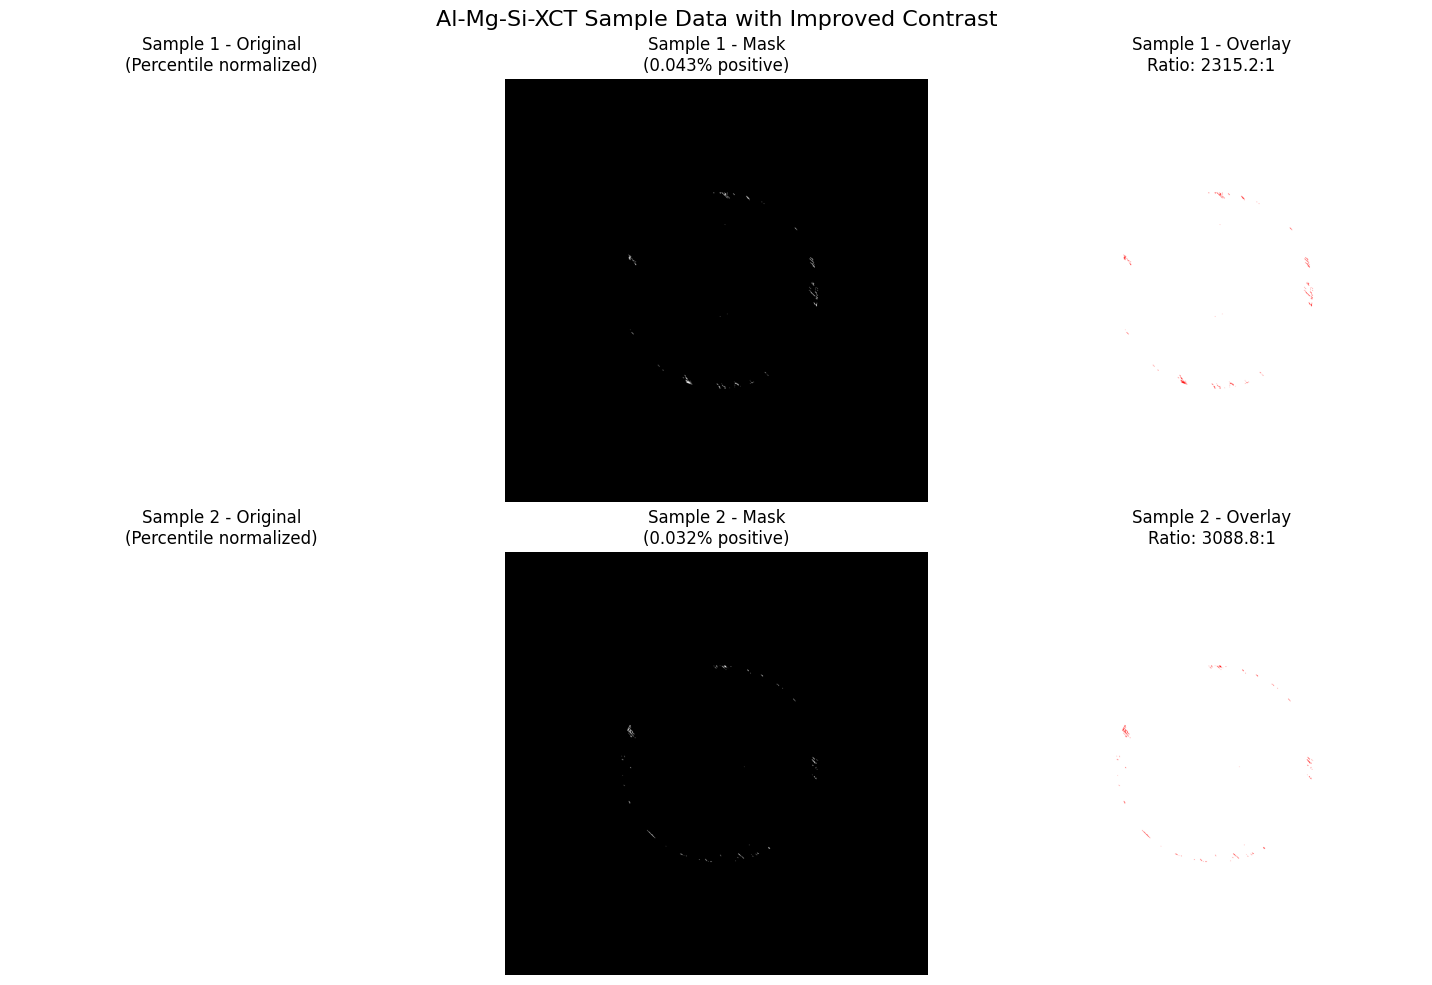


Starting Al-Mg-Si-XCT quick test with improved loss functions...
Starting MDSMG Al-Mg-Si-XCT Quick Test (10 epochs) on cuda
Total experiments to run: 4
Running experiment 1/4: resnet50_unet_imagenet
EXPERIMENT: Al-Mg-Si-XCT | resnet50 | unet | imagenet
Loading dataset: Al-Mg-Si-XCT
Image directory: ./Al-Mg-Si-XCT/images
Mask directory: ./Al-Mg-Si-XCT/masks
Found 150 valid image-mask pairs
Dataset split: 120 train, 30 validation
Creating encoder: resnet50 with imagenet pretraining
✓ ResNet50 with ImageNet weights loaded
Training resnet50_unet_imagenet for 10 epochs on cuda
Using Combined Loss (Enhanced Focal + Tversky) for extreme class imbalance
------------------------------------------------------------


Epoch 1/10: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it, train_loss=0.3993]


Epoch  1: Train Loss: 0.4000 | Val Loss: 0.4006 | Val IoU: 0.0238 | Val Dice: 0.0464
  ✓ New best IoU: 0.0238


Epoch 2/10: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it, train_loss=0.3991]


Epoch  2: Train Loss: 0.3990 | Val Loss: 0.3989 | Val IoU: 0.0326 | Val Dice: 0.0631
  ✓ New best IoU: 0.0326


Epoch 3/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3988]


Epoch  3: Train Loss: 0.3986 | Val Loss: 0.3985 | Val IoU: 0.0337 | Val Dice: 0.0650
  ✓ New best IoU: 0.0337


Epoch 4/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3983]


Epoch  4: Train Loss: 0.3983 | Val Loss: 0.3982 | Val IoU: 0.0384 | Val Dice: 0.0738
  ✓ New best IoU: 0.0384


Epoch 5/10: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it, train_loss=0.3975]


Epoch  5: Train Loss: 0.3979 | Val Loss: 0.3977 | Val IoU: 0.0483 | Val Dice: 0.0919
  ✓ New best IoU: 0.0483


Epoch 6/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3969]


Epoch  6: Train Loss: 0.3973 | Val Loss: 0.3973 | Val IoU: 0.0725 | Val Dice: 0.1348
  ✓ New best IoU: 0.0725


Epoch 7/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3958]


Epoch  7: Train Loss: 0.3965 | Val Loss: 0.3964 | Val IoU: 0.0553 | Val Dice: 0.1045


Epoch 8/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3952]


Epoch  8: Train Loss: 0.3949 | Val Loss: 0.3938 | Val IoU: 0.0462 | Val Dice: 0.0881


Epoch 9/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3897]


Epoch  9: Train Loss: 0.3915 | Val Loss: 0.3897 | Val IoU: 0.0775 | Val Dice: 0.1434
  ✓ New best IoU: 0.0775


Epoch 10/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3719]


Epoch 10: Train Loss: 0.3847 | Val Loss: 0.3859 | Val IoU: 0.0685 | Val Dice: 0.1278
Training completed! Best validation IoU: 0.0775
Final validation Dice: 0.1278
RESULTS: IoU=0.0775 | Dice=0.1278
Experiment 1/4 completed: resnet50_unet_imagenet
  Best IoU: 0.0775
  Best Dice: 0.1278
------------------------------------------------------------
Running experiment 2/4: resnet50_unet_micronet
EXPERIMENT: Al-Mg-Si-XCT | resnet50 | unet | micronet
Loading dataset: Al-Mg-Si-XCT
Image directory: ./Al-Mg-Si-XCT/images
Mask directory: ./Al-Mg-Si-XCT/masks
Found 150 valid image-mask pairs
Dataset split: 120 train, 30 validation
Creating encoder: resnet50 with micronet pretraining
Successfully loaded MicroNet weights for micronet-resnet50 from resnet50_micronet_weights.pth
✓ ResNet50 with MicroNet weights loaded
Training resnet50_unet_micronet for 10 epochs on cuda
Using Combined Loss (Enhanced Focal + Tversky) for extreme class imbalance
----------------------------------------------------------

Epoch 1/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.4004]


Epoch  1: Train Loss: 0.4019 | Val Loss: 0.4012 | Val IoU: 0.0083 | Val Dice: 0.0165
  ✓ New best IoU: 0.0083


Epoch 2/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3998]


Epoch  2: Train Loss: 0.4002 | Val Loss: 0.4000 | Val IoU: 0.0139 | Val Dice: 0.0273
  ✓ New best IoU: 0.0139


Epoch 3/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3995]


Epoch  3: Train Loss: 0.3998 | Val Loss: 0.3997 | Val IoU: 0.0149 | Val Dice: 0.0293
  ✓ New best IoU: 0.0149


Epoch 4/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3995]


Epoch  4: Train Loss: 0.3996 | Val Loss: 0.3994 | Val IoU: 0.0159 | Val Dice: 0.0313
  ✓ New best IoU: 0.0159


Epoch 5/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3994]


Epoch  5: Train Loss: 0.3993 | Val Loss: 0.3993 | Val IoU: 0.0150 | Val Dice: 0.0294


Epoch 6/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3992]


Epoch  6: Train Loss: 0.3990 | Val Loss: 0.3990 | Val IoU: 0.0186 | Val Dice: 0.0364
  ✓ New best IoU: 0.0186


Epoch 7/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3983]


Epoch  7: Train Loss: 0.3987 | Val Loss: 0.3987 | Val IoU: 0.0218 | Val Dice: 0.0426
  ✓ New best IoU: 0.0218


Epoch 8/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3978]


Epoch  8: Train Loss: 0.3984 | Val Loss: 0.3982 | Val IoU: 0.0405 | Val Dice: 0.0777
  ✓ New best IoU: 0.0405


Epoch 9/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3980]


Epoch  9: Train Loss: 0.3981 | Val Loss: 0.3980 | Val IoU: 0.0261 | Val Dice: 0.0507


Epoch 10/10: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, train_loss=0.3973]


Epoch 10: Train Loss: 0.3977 | Val Loss: 0.3976 | Val IoU: 0.0231 | Val Dice: 0.0451
Training completed! Best validation IoU: 0.0405
Final validation Dice: 0.0451
RESULTS: IoU=0.0405 | Dice=0.0451
Experiment 2/4 completed: resnet50_unet_micronet
  Best IoU: 0.0405
  Best Dice: 0.0451
------------------------------------------------------------
Running experiment 3/4: resnet50_deeplabv3plus_imagenet
EXPERIMENT: Al-Mg-Si-XCT | resnet50 | deeplabv3plus | imagenet
Loading dataset: Al-Mg-Si-XCT
Image directory: ./Al-Mg-Si-XCT/images
Mask directory: ./Al-Mg-Si-XCT/masks
Found 150 valid image-mask pairs
Dataset split: 120 train, 30 validation
Creating encoder: resnet50 with imagenet pretraining
✓ ResNet50 with ImageNet weights loaded
Training resnet50_deeplabv3plus_imagenet for 10 epochs on cuda
Using Combined Loss (Enhanced Focal + Tversky) for extreme class imbalance
------------------------------------------------------------


Epoch 1/10:  30%|███       | 9/30 [00:13<00:31,  1.49s/it, train_loss=0.4009]


KeyboardInterrupt: 

In [11]:
# Material Data Science Model Garden (MDSMG) Experiment
# Systematic Evaluation of Encoder-Decoder Architectures for Material Image Segmentation
# Al-Mg-Si-XCT Dataset Experiment - IMPROVED FOR CLASS IMBALANCE

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
import segmentation_models_pytorch as smp
from huggingface_hub import hf_hub_download
import timm

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name())

class MaterialDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, image_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.image_size = image_size
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Load image with proper handling for different bit depths
        if image_path.endswith('.tif') or image_path.endswith('.tiff'):
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            # Handle different bit depths (uint16, uint8, etc.)
            if image.dtype == np.uint16:
                # Use percentile-based normalization for better contrast
                p1, p99 = np.percentile(image, (1, 99))
                image = np.clip((image - p1) / (p99 - p1) * 255, 0, 255).astype(np.uint8)
            elif image.dtype != np.uint8:
                image = image.astype(np.uint8)
                
        else:
            image = np.array(Image.open(image_path).convert('RGB'))
            
        # Load mask with proper handling
        if mask_path.endswith('.tif') or mask_path.endswith('.tiff'):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Handle different mask bit depths
            if mask.dtype == np.uint16:
                mask_max = mask.max()
                if mask_max > 255:
                    mask = (mask.astype(np.float32) / mask_max * 255.0).astype(np.uint8)
                else:
                    mask = mask.astype(np.uint8)
            elif mask.dtype != np.uint8:
                mask = mask.astype(np.uint8)
        else:
            mask = np.array(Image.open(mask_path).convert('L'))
        
        # Resize images
        image = cv2.resize(image, self.image_size)
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
        
        # More careful mask binarization
        unique_vals = np.unique(mask)
        
        # Create binary mask
        if len(unique_vals) == 2 and 0 in unique_vals:
            mask = (mask > 0).astype(np.uint8)
        else:
            threshold = np.percentile(mask[mask > 0], 50) if np.any(mask > 0) else 127
            mask = (mask > threshold).astype(np.uint8)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            # Convert to float32 before creating tensor
            image = image.astype(np.float32)
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            mask = torch.from_numpy(mask.astype(np.float32)).float()
            
        return image, mask

def load_dataset_paths(base_path, dataset_name):
    dataset_path = os.path.join(base_path, dataset_name)
    image_dir = os.path.join(dataset_path, 'images')
    mask_dir = os.path.join(dataset_path, 'masks')
    
    print(f"Loading dataset: {dataset_name}")
    print(f"Image directory: {image_dir}")
    print(f"Mask directory: {mask_dir}")
    
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        print(f"Warning: Directory does not exist for {dataset_name}")
        return [], []
    
    image_extensions = ['*.png', '*.tif', '*.tiff', '*.jpg', '*.jpeg']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(image_dir, ext)))
    
    mask_paths = []
    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        img_name_no_ext = os.path.splitext(img_name)[0]
        
        for mask_ext in ['png', 'tif', 'tiff']:
            mask_path = os.path.join(mask_dir, f"{img_name_no_ext}.{mask_ext}")
            if os.path.exists(mask_path):
                mask_paths.append(mask_path)
                break
    
    valid_pairs = []
    valid_mask_paths = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_pairs.append(img_path)
            valid_mask_paths.append(mask_path)
    
    print(f"Found {len(valid_pairs)} valid image-mask pairs")
    return valid_pairs, valid_mask_paths

base_path = "."
datasets = ['Al-Mg-Si-XCT', 'AFM', 'Bond-Wire-XCT', 'Carbon', 'Fractography']

dataset_info = {}
for dataset_name in datasets:
    image_paths, mask_paths = load_dataset_paths(base_path, dataset_name)
    dataset_info[dataset_name] = len(image_paths)
    
print("\nDataset Summary:")
for name, count in dataset_info.items():
    print(f"{name}: {count} image-mask pairs")

def load_micronet_weights(model_name='micronet-resnet50'):
    try:
        if model_name == 'micronet-resnet50':
            filenames_to_try = [
                "resnet50_micronet_weights.pth",
                "resnet50_imagenet-micronet_weights.pth", 
                "pytorch_model.bin"
            ]
            repo_id = "jstuckner/microscopy-resnet50-micronet"
            
        elif model_name == 'micronet-se_resnext101':
            filenames_to_try = [
                "resnext101_micronet_weights.pth",
                "resnext101_imagenet-micronet_weights.pth",
                "pytorch_model.bin"
            ]
            repo_id = "jstuckner/microscopy-resnext101-micronet"
        else:
            raise ValueError(f"Unknown MicroNet model: {model_name}")
        
        weights = None
        for filename in filenames_to_try:
            try:
                model_path = hf_hub_download(repo_id=repo_id, filename=filename)
                weights = torch.load(model_path, map_location='cpu')
                print(f"Successfully loaded MicroNet weights for {model_name} from {filename}")
                break
            except Exception as e:
                print(f"Failed to load {filename}: {str(e)}")
                continue
        
        if weights is None:
            print(f"Failed to load any weights for {model_name}")
            
        return weights
    
    except Exception as e:
        print(f"Failed to load MicroNet weights for {model_name}: {str(e)}")
        return None

print("Testing MicroNet model loading...")
micronet_resnet50_weights = load_micronet_weights('micronet-resnet50')
micronet_se_resnext101_weights = load_micronet_weights('micronet-se_resnext101')

if micronet_resnet50_weights:
    print("✓ MicroNet ResNet50 weights loaded successfully")
    print(f"  Keys in state dict: {len(micronet_resnet50_weights.keys())}")
    
if micronet_se_resnext101_weights:
    print("✓ MicroNet SE-ResNeXt101 weights loaded successfully")
    print(f"  Keys in state dict: {len(micronet_se_resnext101_weights.keys())}")

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

def create_encoder(encoder_name='resnet50', pretrained='imagenet'):
    print(f"Creating encoder: {encoder_name} with {pretrained} pretraining")
    
    if encoder_name == 'resnet50':
        if pretrained == 'imagenet':
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights='imagenet')
            print("✓ ResNet50 with ImageNet weights loaded")
        elif pretrained == 'micronet':
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights=None)
            micronet_weights = load_micronet_weights('micronet-resnet50')
            if micronet_weights:
                try:
                    encoder.load_state_dict(micronet_weights, strict=False)
                    print("✓ ResNet50 with MicroNet weights loaded")
                except Exception as e:
                    print(f"⚠ Failed to load MicroNet weights strictly, trying partial loading: {str(e)}")
                    model_dict = encoder.state_dict()
                    pretrained_dict = {k: v for k, v in micronet_weights.items() 
                                     if k in model_dict and v.shape == model_dict[k].shape}
                    model_dict.update(pretrained_dict)
                    encoder.load_state_dict(model_dict)
                    print(f"✓ ResNet50 with partial MicroNet weights loaded ({len(pretrained_dict)} layers)")
            else:
                print("⚠ Failed to load MicroNet weights, using random initialization")
        else:
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights=None)
            print("✓ ResNet50 with random weights")
            
        encoder_channels = [3, 64, 256, 512, 1024, 2048]
    
    elif encoder_name == 'se_resnext101':
        if pretrained == 'imagenet':
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights='imagenet')
            print("✓ SE-ResNeXt101 with ImageNet weights loaded")
        elif pretrained == 'micronet':
            print("⚠ MicroNet weights for SE-ResNeXt101 have architecture mismatch")
            print("  Using ImageNet pretrained weights as fallback")
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights='imagenet')
            
            micronet_weights = load_micronet_weights('micronet-se_resnext101')
            if micronet_weights:
                try:
                    model_dict = encoder.state_dict()
                    pretrained_dict = {}
                    for k, v in micronet_weights.items():
                        if k in model_dict and v.shape == model_dict[k].shape:
                            pretrained_dict[k] = v
                    
                    if len(pretrained_dict) > 0:
                        model_dict.update(pretrained_dict)
                        encoder.load_state_dict(model_dict)
                        print(f"✓ Loaded {len(pretrained_dict)} compatible layers from MicroNet")
                    else:
                        print("✗ No compatible layers found in MicroNet weights")
                        
                except Exception as e:
                    print(f"✗ Failed to load any MicroNet weights: {str(e)}")
            
        else:
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights=None)
            print("✓ SE-ResNeXt101 with random weights")
            
        encoder_channels = [3, 64, 256, 512, 1024, 2048]
    
    return encoder, encoder_channels

class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, n_classes=1):
        super(UNetDecoder, self).__init__()
        
        self.decoder_blocks = nn.ModuleList()
        
        for i in range(len(decoder_channels)):
            if i == 0:
                in_ch = encoder_channels[-1]
            else:
                in_ch = decoder_channels[i-1]
            
            out_ch = decoder_channels[i]
            skip_ch = encoder_channels[-(i+2)] if i < len(encoder_channels)-1 else 0
            
            block = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
                nn.Conv2d(out_ch + skip_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
            
            self.decoder_blocks.append(block)
        
        self.final_conv = nn.Conv2d(decoder_channels[-1], n_classes, kernel_size=1)
        
    def forward(self, encoder_features):
        x = encoder_features[-1]
        
        for i, decoder_block in enumerate(self.decoder_blocks):
            x = decoder_block[0](x)
            
            if i < len(encoder_features) - 1:
                skip = encoder_features[-(i+2)]
                if x.shape[2:] != skip.shape[2:]:
                    x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
                x = torch.cat([x, skip], dim=1)
            
            for layer in decoder_block[1:]:
                x = layer(x)
        
        return self.final_conv(x)

class ASPPModule(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPPModule, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.atrous_convs = nn.ModuleList()
        for rate in atrous_rates:
            self.atrous_convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.project = nn.Sequential(
            nn.Conv2d(out_channels * (2 + len(atrous_rates)), out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        
    def forward(self, x):
        h, w = x.shape[2:]
        
        feat1 = self.conv1(x)
        atrous_feats = [conv(x) for conv in self.atrous_convs]
        global_feat = self.global_pool(x)
        global_feat = F.interpolate(global_feat, size=(h, w), mode='bilinear', align_corners=False)
        
        concat_feat = torch.cat([feat1] + atrous_feats + [global_feat], dim=1)
        return self.project(concat_feat)

class DeepLabV3Decoder(nn.Module):
    def __init__(self, encoder_channels, n_classes=1):
        super(DeepLabV3Decoder, self).__init__()
        self.aspp = ASPPModule(encoder_channels[-1], 256, [6, 12, 18])
        self.classifier = nn.Conv2d(256, n_classes, 1)
        
    def forward(self, encoder_features):
        x = encoder_features[-1]
        x = self.aspp(x)
        x = self.classifier(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

class DeepLabV3PlusDecoder(nn.Module):
    def __init__(self, encoder_channels, n_classes=1):
        super(DeepLabV3PlusDecoder, self).__init__()
        
        self.aspp = ASPPModule(encoder_channels[-1], 256, [6, 12, 18])
        low_level_channels = encoder_channels[1]
        
        self.low_level_proj = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256 + 48, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Conv2d(256, n_classes, 1)
        
    def forward(self, encoder_features):
        low_level = encoder_features[1]
        high_level = encoder_features[-1]
        
        high_level = self.aspp(high_level)
        high_level = F.interpolate(high_level, size=low_level.shape[2:], mode='bilinear', align_corners=False)
        
        low_level = self.low_level_proj(low_level)
        
        concat_feat = torch.cat([high_level, low_level], dim=1)
        decoded = self.decoder(concat_feat)
        output = self.classifier(decoded)
        
        output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
        
        return output

class MaterialSegmentationModel(nn.Module):
    def __init__(self, encoder_name='resnet50', decoder_name='unet', pretrained='imagenet', n_classes=1):
        super(MaterialSegmentationModel, self).__init__()
        
        self.encoder, encoder_channels = create_encoder(encoder_name, pretrained)
        
        if decoder_name == 'unet':
            self.decoder = UNetDecoder(encoder_channels[1:], [256, 128, 64, 32], n_classes)
        elif decoder_name == 'deeplabv3':
            self.decoder = DeepLabV3Decoder(encoder_channels[1:], n_classes)
        elif decoder_name == 'deeplabv3plus':
            self.decoder = DeepLabV3PlusDecoder(encoder_channels, n_classes)
        
        self.config = f"{encoder_name}_{decoder_name}_{pretrained}"
        
    def forward(self, x):
        encoder_features = self.encoder(x)
        
        if hasattr(self.decoder, '__class__') and self.decoder.__class__.__name__ == 'DeepLabV3PlusDecoder':
            output = self.decoder(encoder_features)
        else:
            output = self.decoder(encoder_features[1:])
        
        return output

# IMPROVED LOSS FUNCTIONS FOR EXTREME CLASS IMBALANCE
class AdaptiveWeightedBCELoss(nn.Module):
    def __init__(self, min_pos_weight=100.0, max_pos_weight=1000.0):
        super(AdaptiveWeightedBCELoss, self).__init__()
        self.min_pos_weight = min_pos_weight
        self.max_pos_weight = max_pos_weight
        
    def forward(self, inputs, targets):
        # Calculate dynamic positive weight based on class distribution
        pos_pixels = targets.sum()
        neg_pixels = (targets.numel() - pos_pixels)
        
        if pos_pixels > 0:
            # Much higher weight for positive class
            dynamic_pos_weight = (neg_pixels / pos_pixels).clamp(
                min=self.min_pos_weight, 
                max=self.max_pos_weight
            )
        else:
            dynamic_pos_weight = torch.tensor(self.min_pos_weight)
            
        print(f"Adaptive pos_weight: {dynamic_pos_weight:.1f}")
        return F.binary_cross_entropy_with_logits(inputs, targets, 
                                                pos_weight=dynamic_pos_weight)

# Enhanced Focal Loss with higher gamma for extreme imbalance
class EnhancedFocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=4.0):  # Increased alpha and gamma
        super(EnhancedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        
        # Apply alpha weighting - higher for positive class
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        focal_loss = alpha_t * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

# Tversky Loss - better for imbalanced segmentation
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha  # Weight for false positives
        self.beta = beta    # Weight for false negatives (higher for recall)
        self.smooth = smooth
        
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        
        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # True positives, false positives, false negatives
        tp = (inputs * targets).sum()
        fp = ((1 - targets) * inputs).sum()
        fn = (targets * (1 - inputs)).sum()
        
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky

# Combined Loss for extreme imbalance
class CombinedImbalanceLoss(nn.Module):
    def __init__(self, focal_weight=0.6, tversky_weight=0.4):
        super(CombinedImbalanceLoss, self).__init__()
        self.focal_loss = EnhancedFocalLoss(alpha=0.9, gamma=4.0)
        self.tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)
        self.focal_weight = focal_weight
        self.tversky_weight = tversky_weight
        
    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        tversky = self.tversky_loss(inputs, targets)
        return self.focal_weight * focal + self.tversky_weight * tversky

def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    # Ensure both tensors have same shape
    if target.dim() == 3 and pred.dim() == 4:
        target = target.unsqueeze(1)
    elif target.dim() == 4 and pred.dim() == 3:
        pred = pred.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    # Ensure both tensors have same shape
    if target.dim() == 3 and pred.dim() == 4:
        target = target.unsqueeze(1)
    elif target.dim() == 4 and pred.dim() == 3:
        pred = pred.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):  # Reduced to 10 epochs
    model = model.to(device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Higher learning rate for faster convergence in short training
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
    
    # Use Combined Loss for extreme class imbalance
    criterion = CombinedImbalanceLoss(focal_weight=0.6, tversky_weight=0.4)
    
    # More aggressive scheduler for short training
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)
    
    best_val_iou = 0
    history = {
        'train_losses': [],
        'val_losses': [],
        'val_ious': [],
        'val_dices': []
    }
    
    print(f"Training {model.config} for {num_epochs} epochs on {device}")
    print(f"Using Combined Loss (Enhanced Focal + Tversky) for extreme class imbalance")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            
            if outputs.shape[2:] != masks.shape[1:]:
                outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            pbar.set_postfix({'train_loss': f'{loss.item():.4f}'})
            
            if train_batches % 10 == 0:
                torch.cuda.empty_cache()
        
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_batches = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).float()
                
                outputs = model(images)
                if outputs.shape[2:] != masks.shape[1:]:
                    outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
                
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                
                # Ensure consistent dimensions for metrics
                if masks.dim() == 3:
                    masks_for_metrics = masks.unsqueeze(1)
                else:
                    masks_for_metrics = masks
                
                if outputs.dim() == 3:
                    outputs_for_metrics = outputs.unsqueeze(1)
                else:
                    outputs_for_metrics = outputs
                
                val_iou += iou_score(outputs_for_metrics, masks_for_metrics).item()
                val_dice += dice_coefficient(outputs_for_metrics, masks_for_metrics).item()
                val_batches += 1
        
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches
        avg_val_iou = val_iou / val_batches
        avg_val_dice = val_dice / val_batches
        
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['val_ious'].append(avg_val_iou)
        history['val_dices'].append(avg_val_dice)
        
        scheduler.step(avg_val_loss)
        
        # Print results every epoch for 10-epoch training
        print(f'Epoch {epoch+1:2d}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f} | Val Dice: {avg_val_dice:.4f}')
        
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), f'best_{model.config}.pth')
            print(f'  ✓ New best IoU: {best_val_iou:.4f}')
        
        torch.cuda.empty_cache()
    
    history['best_val_iou'] = best_val_iou
    print(f"Training completed! Best validation IoU: {best_val_iou:.4f}")
    print(f"Final validation Dice: {history['val_dices'][-1]:.4f}")
    return history

def run_single_experiment(dataset_name, encoder_name, decoder_name, pretrained, device='cuda'):
    print(f"EXPERIMENT: {dataset_name} | {encoder_name} | {decoder_name} | {pretrained}")
    print("="*80)
    
    image_paths, mask_paths = load_dataset_paths(".", dataset_name)
    
    if len(image_paths) < 4:
        print(f"Insufficient data for {dataset_name}: {len(image_paths)} samples")
        return None, None
    
    train_images, val_images, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )
    
    print(f"Dataset split: {len(train_images)} train, {len(val_images)} validation")
    
    train_dataset = MaterialDataset(train_images, train_masks, image_size=(256, 256))
    val_dataset = MaterialDataset(val_images, val_masks, image_size=(256, 256))
    
    # Increased batch size for faster training
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
    
    model = MaterialSegmentationModel(encoder_name, decoder_name, pretrained, n_classes=1)
    
    # Only 10 epochs for quick testing
    history = train_model(model, train_loader, val_loader, num_epochs=10, device=device)
    
    result = {
        'dataset': dataset_name,
        'encoder': encoder_name,
        'decoder': decoder_name,
        'pretrained': pretrained,
        'config': f"{encoder_name}_{decoder_name}_{pretrained}",
        'train_samples': len(train_images),
        'val_samples': len(val_images),
        'best_val_iou': history['best_val_iou'],
        'final_val_dice': history['val_dices'][-1],
        'final_train_loss': history['train_losses'][-1],
        'final_val_loss': history['val_losses'][-1]
    }
    
    print(f"RESULTS: IoU={result['best_val_iou']:.4f} | Dice={result['final_val_dice']:.4f}")
    
    return result, history

def run_almgsi_quick_test():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Starting MDSMG Al-Mg-Si-XCT Quick Test (10 epochs) on {device}")
    
    datasets = ['Al-Mg-Si-XCT']
    # Test with fewer configurations for quick results
    encoders = ['resnet50']  # Start with ResNet50 only
    decoders = ['unet', 'deeplabv3plus']  # Test best performing decoders
    pretrained_options = ['imagenet', 'micronet']
    
    results = []
    histories = {}
    experiment_count = 0
    
    total_experiments = len(datasets) * len(encoders) * len(decoders) * len(pretrained_options)
    print(f"Total experiments to run: {total_experiments}")
    
    for dataset_name in datasets:
        for encoder in encoders:
            for decoder in decoders:
                for pretrained in pretrained_options:
                    experiment_count += 1
                    
                    print(f"Running experiment {experiment_count}/{total_experiments}: {encoder}_{decoder}_{pretrained}")
                    
                    result, history = run_single_experiment(
                        dataset_name, encoder, decoder, pretrained, device
                    )
                    
                    if result and history:
                        results.append(result)
                        histories[result['config'] + '_' + dataset_name] = history
                        print(f"Experiment {experiment_count}/{total_experiments} completed: {result['config']}")
                        print(f"  Best IoU: {result['best_val_iou']:.4f}")
                        print(f"  Best Dice: {result['final_val_dice']:.4f}")
                    else:
                        print(f"Experiment {experiment_count}/{total_experiments} failed or skipped")
                    
                    print("-" * 60)
    
    if results:
        results_df = pd.DataFrame(results)
        results_df.to_csv('almgsi_quick_test_results.csv', index=False)
        
        print(f"Al-Mg-Si-XCT quick test completed!")
        print(f"Total successful experiments: {len(results)}")
        print(f"Results saved to: almgsi_quick_test_results.csv")
        
        # Quick analysis
        print("\nQUICK RESULTS ANALYSIS:")
        print("="*40)
        best_idx = results_df['best_val_iou'].idxmax()
        best_config = results_df.loc[best_idx]
        print(f"Best configuration: {best_config['config']}")
        print(f"Best IoU: {best_config['best_val_iou']:.4f}")
        print(f"Best Dice: {best_config['final_val_dice']:.4f}")
        
        print(f"\nAll Results:")
        for _, row in results_df.iterrows():
            print(f"  {row['config']}: IoU={row['best_val_iou']:.4f}, Dice={row['final_val_dice']:.4f}")
        
        return results_df, histories
    else:
        print("No successful experiments completed")
        return pd.DataFrame(), {}

def analyze_class_imbalance():
    """Analyze the class imbalance in the Al-Mg-Si-XCT dataset"""
    print("ANALYZING CLASS IMBALANCE IN AL-MG-SI-XCT DATASET")
    print("="*60)
    
    image_paths, mask_paths = load_dataset_paths(".", "Al-Mg-Si-XCT")
    
    if len(image_paths) == 0:
        print("No Al-Mg-Si-XCT data found")
        return
    
    total_pixels = 0
    total_positive_pixels = 0
    imbalance_ratios = []
    
    print(f"Analyzing {len(mask_paths)} masks...")
    
    for i, mask_path in enumerate(mask_paths[:min(10, len(mask_paths))]):  # Analyze first 10 masks
        if mask_path.endswith('.tif') or mask_path.endswith('.tiff'):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask.dtype == np.uint16:
                mask = (mask / 65535.0 * 255.0).astype(np.uint8)
        else:
            mask = np.array(Image.open(mask_path).convert('L'))
        
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        mask_binary = (mask > 127).astype(np.uint8)
        
        pixels = mask_binary.size
        positive_pixels = np.sum(mask_binary)
        negative_pixels = pixels - positive_pixels
        
        total_pixels += pixels
        total_positive_pixels += positive_pixels
        
        if positive_pixels > 0:
            ratio = negative_pixels / positive_pixels
            imbalance_ratios.append(ratio)
            print(f"Mask {i+1}: {positive_pixels:6d}/{pixels:6d} positive ({positive_pixels/pixels*100:5.2f}%) - Ratio: {ratio:6.1f}:1")
        else:
            print(f"Mask {i+1}: {positive_pixels:6d}/{pixels:6d} positive ({positive_pixels/pixels*100:5.2f}%) - Ratio: ∞:1 (no positive pixels)")
    
    overall_ratio = (total_pixels - total_positive_pixels) / max(total_positive_pixels, 1)
    avg_ratio = np.mean(imbalance_ratios) if imbalance_ratios else float('inf')
    
    print(f"\nOVERALL STATISTICS:")
    print(f"Total pixels analyzed: {total_pixels:,}")
    print(f"Total positive pixels: {total_positive_pixels:,} ({total_positive_pixels/total_pixels*100:.3f}%)")
    print(f"Overall imbalance ratio: {overall_ratio:.1f}:1")
    print(f"Average imbalance ratio: {avg_ratio:.1f}:1")
    
    print(f"\nRECOMMENDED LOSS FUNCTION SETTINGS:")
    print(f"- Focal Loss gamma: 4.0-5.0 (high focus on hard examples)")
    print(f"- Focal Loss alpha: 0.9-0.95 (high weight for positive class)")
    print(f"- BCE pos_weight: {min(overall_ratio, 1000):.0f} (capped at 1000)")
    print(f"- Tversky Loss beta (FN weight): 0.7-0.8 (high recall focus)")

def inspect_almgsi_data():
    print("AL-MG-SI-XCT DATA INSPECTION")
    print("-" * 40)
    
    image_paths, mask_paths = load_dataset_paths(".", "Al-Mg-Si-XCT")
    
    if len(image_paths) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Al-Mg-Si-XCT Sample Data with Improved Contrast', fontsize=16)
        
        # Show 2 different samples
        for row in range(2):
            sample_idx = row
            if sample_idx >= len(image_paths):
                sample_idx = 0
            
            # Load and process image with proper bit depth handling
            if image_paths[sample_idx].endswith('.tif'):
                image = cv2.imread(image_paths[sample_idx], cv2.IMREAD_UNCHANGED)
                print(f"Sample {row+1} - Original image dtype: {image.dtype}, shape: {image.shape}")
                print(f"Image value range: {image.min()} - {image.max()}")
                
                if len(image.shape) == 3:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                elif len(image.shape) == 2:
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                
                # Use percentile-based normalization for better contrast
                if image.dtype == np.uint16:
                    p1, p99 = np.percentile(image, (1, 99))
                    image_display = np.clip((image - p1) / (p99 - p1) * 255, 0, 255).astype(np.uint8)
                    print(f"Applied percentile normalization: p1={p1}, p99={p99}")
                else:
                    image_display = image.astype(np.uint8)
            else:
                image_display = np.array(Image.open(image_paths[sample_idx]).convert('RGB'))
            
            # Load and process mask
            if mask_paths[sample_idx].endswith('.tif'):
                mask = cv2.imread(mask_paths[sample_idx], cv2.IMREAD_GRAYSCALE)
                print(f"Sample {row+1} - Original mask dtype: {mask.dtype}, shape: {mask.shape}")
                print(f"Mask value range: {mask.min()} - {mask.max()}")
                print(f"Mask unique values: {np.unique(mask)}")
                
                if mask.dtype == np.uint16:
                    mask_display = (mask / 65535.0 * 255.0).astype(np.uint8)
                else:
                    mask_display = mask.astype(np.uint8)
            else:
                mask_display = np.array(Image.open(mask_paths[sample_idx]).convert('L'))
            
            # Calculate mask statistics
            mask_binary = (mask_display > 127).astype(np.uint8)
            total_pixels = mask_binary.size
            positive_pixels = np.sum(mask_binary)
            negative_pixels = total_pixels - positive_pixels
            imbalance_ratio = negative_pixels / max(positive_pixels, 1)
            
            print(f"Sample {row+1} - Mask statistics:")
            print(f"  Total pixels: {total_pixels}")
            print(f"  Positive pixels: {positive_pixels} ({positive_pixels/total_pixels*100:.2f}%)")
            print(f"  Negative pixels: {negative_pixels} ({negative_pixels/total_pixels*100:.2f}%)")
            print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")
            
            # Display images
            axes[row, 0].imshow(image_display)
            axes[row, 0].set_title(f'Sample {row+1} - Original\n(Percentile normalized)')
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(mask_display, cmap='gray')
            axes[row, 1].set_title(f'Sample {row+1} - Mask\n({positive_pixels/total_pixels*100:.3f}% positive)')
            axes[row, 1].axis('off')
            
            # Create better overlay
            overlay = image_display.copy().astype(np.float32) / 255.0
            # Highlight positive regions in red
            overlay[:, :, 0] = np.where(mask_binary > 0, 1.0, overlay[:, :, 0])
            overlay[:, :, 1] = np.where(mask_binary > 0, 0.0, overlay[:, :, 1])
            overlay[:, :, 2] = np.where(mask_binary > 0, 0.0, overlay[:, :, 2])
            
            axes[row, 2].imshow(np.clip(overlay, 0, 1))
            axes[row, 2].set_title(f'Sample {row+1} - Overlay\nRatio: {imbalance_ratio:.1f}:1')
            axes[row, 2].axis('off')
        
        print(f"Found {len(image_paths)} Al-Mg-Si-XCT image-mask pairs")
        
        plt.tight_layout()
        plt.savefig('almgsi_improved_sample_data.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No Al-Mg-Si-XCT data found")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("Starting Al-Mg-Si-XCT class imbalance analysis...")
analyze_class_imbalance()

print("\nStarting Al-Mg-Si-XCT data inspection...")
inspect_almgsi_data()

print("\nStarting Al-Mg-Si-XCT quick test with improved loss functions...")
almgsi_results, almgsi_histories = run_almgsi_quick_test()

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
import segmentation_models_pytorch as smp
from huggingface_hub import hf_hub_download
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name())

def extract_smart_patches(image_path, mask_path, patch_size=128, stride=64, min_foreground_ratio=0.001):
    try:
        if image_path.endswith('.tif') or image_path.endswith('.tiff'):
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            if image.dtype == np.uint16:
                p1, p99 = np.percentile(image, (1, 99))
                image = np.clip((image - p1) / (p99 - p1) * 255, 0, 255).astype(np.uint8)
            elif image.dtype != np.uint8:
                image = image.astype(np.uint8)
        else:
            image = np.array(Image.open(image_path).convert('RGB'))
            
        if mask_path.endswith('.tif') or mask_path.endswith('.tiff'):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask.dtype == np.uint16:
                mask_max = mask.max()
                if mask_max > 255:
                    mask = (mask.astype(np.float32) / mask_max * 255.0).astype(np.uint8)
                else:
                    mask = mask.astype(np.uint8)
            elif mask.dtype != np.uint8:
                mask = mask.astype(np.uint8)
        else:
            mask = np.array(Image.open(mask_path).convert('L'))
        
        mask = (mask > 127).astype(np.uint8)
        
        h, w = mask.shape[:2]
        foreground_patches = []
        background_patches = []
        
        for y in range(0, h - patch_size + 1, stride):
            for x in range(0, w - patch_size + 1, stride):
                img_patch = image[y:y+patch_size, x:x+patch_size]
                mask_patch = mask[y:y+patch_size, x:x+patch_size]
                
                foreground_ratio = np.mean(mask_patch)
                
                if foreground_ratio > min_foreground_ratio:
                    foreground_patches.append((img_patch, mask_patch))
                else:
                    background_patches.append((img_patch, mask_patch))
        
        return foreground_patches, background_patches
    
    except Exception as e:
        print(f"Error extracting patches from {image_path}: {e}")
        return [], []

class PatchDataset(Dataset):
    def __init__(self, foreground_patches, background_patches, fg_oversample_ratio=15, 
                 max_bg_patches=3000, patch_size=128, transform=None):
        self.patch_size = patch_size
        self.transform = transform
        
        if len(background_patches) > max_bg_patches:
            background_patches = random.sample(background_patches, max_bg_patches)
        
        self.patches = []
        
        for img_patch, mask_patch in background_patches:
            self.patches.append((img_patch, mask_patch, False))
        
        for _ in range(fg_oversample_ratio):
            for img_patch, mask_patch in foreground_patches:
                self.patches.append((img_patch, mask_patch, True))
        
        print(f"Total patches: {len(self.patches)}")
        print(f"Foreground ratio: {len(foreground_patches) * fg_oversample_ratio / len(self.patches):.3f}")
        
        random.shuffle(self.patches)
        
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        img_patch, mask_patch, need_strong_aug = self.patches[idx]
        
        img_patch = cv2.resize(img_patch, (self.patch_size, self.patch_size))
        mask_patch = cv2.resize(mask_patch, (self.patch_size, self.patch_size), 
                              interpolation=cv2.INTER_NEAREST)
        
        if self.transform:
            if need_strong_aug:
                strong_transform = A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                    A.GaussianBlur(blur_limit=3, p=0.2),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2(),
                ])
                augmented = strong_transform(image=img_patch, mask=mask_patch)
            else:
                augmented = self.transform(image=img_patch, mask=mask_patch)
            
            img_patch = augmented['image']
            mask_patch = augmented['mask']
        else:
            img_patch = img_patch.astype(np.float32)
            img_patch = torch.from_numpy(img_patch.transpose(2, 0, 1)).float() / 255.0
            mask_patch = torch.from_numpy(mask_patch.astype(np.float32)).float()
            
        return img_patch, mask_patch

def load_dataset_paths(base_path, dataset_name):
    dataset_path = os.path.join(base_path, dataset_name)
    image_dir = os.path.join(dataset_path, 'images')
    mask_dir = os.path.join(dataset_path, 'masks')
    
    print(f"Loading dataset: {dataset_name}")
    print(f"Image directory: {image_dir}")
    print(f"Mask directory: {mask_dir}")
    
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        print(f"Warning: Directory does not exist for {dataset_name}")
        return [], []
    
    image_extensions = ['*.png', '*.tif', '*.tiff', '*.jpg', '*.jpeg']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(image_dir, ext)))
    
    mask_paths = []
    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        img_name_no_ext = os.path.splitext(img_name)[0]
        
        for mask_ext in ['png', 'tif', 'tiff']:
            mask_path = os.path.join(mask_dir, f"{img_name_no_ext}.{mask_ext}")
            if os.path.exists(mask_path):
                mask_paths.append(mask_path)
                break
    
    valid_pairs = []
    valid_mask_paths = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_pairs.append(img_path)
            valid_mask_paths.append(mask_path)
    
    print(f"Found {len(valid_pairs)} valid image-mask pairs")
    return valid_pairs, valid_mask_paths

def load_micronet_weights(model_name='micronet-resnet50'):
    try:
        if model_name == 'micronet-resnet50':
            filenames_to_try = [
                "resnet50_micronet_weights.pth",
                "resnet50_imagenet-micronet_weights.pth", 
                "pytorch_model.bin"
            ]
            repo_id = "jstuckner/microscopy-resnet50-micronet"
            
        elif model_name == 'micronet-se_resnext101':
            filenames_to_try = [
                "resnext101_micronet_weights.pth",
                "resnext101_imagenet-micronet_weights.pth",
                "pytorch_model.bin"
            ]
            repo_id = "jstuckner/microscopy-resnext101-micronet"
        else:
            raise ValueError(f"Unknown MicroNet model: {model_name}")
        
        weights = None
        for filename in filenames_to_try:
            try:
                model_path = hf_hub_download(repo_id=repo_id, filename=filename)
                weights = torch.load(model_path, map_location='cpu')
                print(f"Successfully loaded MicroNet weights for {model_name} from {filename}")
                break
            except Exception as e:
                print(f"Failed to load {filename}: {str(e)}")
                continue
        
        if weights is None:
            print(f"Failed to load any weights for {model_name}")
            
        return weights
    
    except Exception as e:
        print(f"Failed to load MicroNet weights for {model_name}: {str(e)}")
        return None

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

def create_encoder(encoder_name='resnet50', pretrained='imagenet'):
    print(f"Creating encoder: {encoder_name} with {pretrained} pretraining")
    
    if encoder_name == 'resnet50':
        if pretrained == 'imagenet':
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights='imagenet')
            print("✓ ResNet50 with ImageNet weights loaded")
        elif pretrained == 'micronet':
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights=None)
            micronet_weights = load_micronet_weights('micronet-resnet50')
            if micronet_weights:
                try:
                    encoder.load_state_dict(micronet_weights, strict=False)
                    print("✓ ResNet50 with MicroNet weights loaded")
                except Exception as e:
                    print(f"⚠ Failed to load MicroNet weights strictly, trying partial loading: {str(e)}")
                    model_dict = encoder.state_dict()
                    pretrained_dict = {k: v for k, v in micronet_weights.items() 
                                     if k in model_dict and v.shape == model_dict[k].shape}
                    model_dict.update(pretrained_dict)
                    encoder.load_state_dict(model_dict)
                    print(f"✓ ResNet50 with partial MicroNet weights loaded ({len(pretrained_dict)} layers)")
            else:
                print("⚠ Failed to load MicroNet weights, using random initialization")
        else:
            encoder = smp.encoders.get_encoder('resnet50', in_channels=3, weights=None)
            print("✓ ResNet50 with random weights")
            
        encoder_channels = [3, 64, 256, 512, 1024, 2048]
    
    elif encoder_name == 'se_resnext101':
        if pretrained == 'imagenet':
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights='imagenet')
            print("✓ SE-ResNeXt101 with ImageNet weights loaded")
        elif pretrained == 'micronet':
            print("⚠ MicroNet weights for SE-ResNeXt101 have architecture mismatch")
            print("  Using ImageNet pretrained weights as fallback")
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights='imagenet')
            
            micronet_weights = load_micronet_weights('micronet-se_resnext101')
            if micronet_weights:
                try:
                    model_dict = encoder.state_dict()
                    pretrained_dict = {}
                    for k, v in micronet_weights.items():
                        if k in model_dict and v.shape == model_dict[k].shape:
                            pretrained_dict[k] = v
                    
                    if len(pretrained_dict) > 0:
                        model_dict.update(pretrained_dict)
                        encoder.load_state_dict(model_dict)
                        print(f"✓ Loaded {len(pretrained_dict)} compatible layers from MicroNet")
                    else:
                        print("✗ No compatible layers found in MicroNet weights")
                        
                except Exception as e:
                    print(f"✗ Failed to load any MicroNet weights: {str(e)}")
            
        else:
            encoder = smp.encoders.get_encoder('se_resnext101_32x4d', in_channels=3, weights=None)
            print("✓ SE-ResNeXt101 with random weights")
            
        encoder_channels = [3, 64, 256, 512, 1024, 2048]
    
    return encoder, encoder_channels

class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, n_classes=1):
        super(UNetDecoder, self).__init__()
        
        self.decoder_blocks = nn.ModuleList()
        
        for i in range(len(decoder_channels)):
            if i == 0:
                in_ch = encoder_channels[-1]
            else:
                in_ch = decoder_channels[i-1]
            
            out_ch = decoder_channels[i]
            skip_ch = encoder_channels[-(i+2)] if i < len(encoder_channels)-1 else 0
            
            block = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
                nn.Conv2d(out_ch + skip_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
            
            self.decoder_blocks.append(block)
        
        self.final_conv = nn.Conv2d(decoder_channels[-1], n_classes, kernel_size=1)
        
    def forward(self, encoder_features):
        x = encoder_features[-1]
        
        for i, decoder_block in enumerate(self.decoder_blocks):
            x = decoder_block[0](x)
            
            if i < len(encoder_features) - 1:
                skip = encoder_features[-(i+2)]
                if x.shape[2:] != skip.shape[2:]:
                    x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
                x = torch.cat([x, skip], dim=1)
            
            for layer in decoder_block[1:]:
                x = layer(x)
        
        return self.final_conv(x)

class ASPPModule(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPPModule, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.atrous_convs = nn.ModuleList()
        for rate in atrous_rates:
            self.atrous_convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.project = nn.Sequential(
            nn.Conv2d(out_channels * (2 + len(atrous_rates)), out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        
    def forward(self, x):
        h, w = x.shape[2:]
        
        feat1 = self.conv1(x)
        atrous_feats = [conv(x) for conv in self.atrous_convs]
        global_feat = self.global_pool(x)
        global_feat = F.interpolate(global_feat, size=(h, w), mode='bilinear', align_corners=False)
        
        concat_feat = torch.cat([feat1] + atrous_feats + [global_feat], dim=1)
        return self.project(concat_feat)

class DeepLabV3Decoder(nn.Module):
    def __init__(self, encoder_channels, n_classes=1):
        super(DeepLabV3Decoder, self).__init__()
        self.aspp = ASPPModule(encoder_channels[-1], 256, [6, 12, 18])
        self.classifier = nn.Conv2d(256, n_classes, 1)
        
    def forward(self, encoder_features):
        x = encoder_features[-1]
        x = self.aspp(x)
        x = self.classifier(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

class DeepLabV3PlusDecoder(nn.Module):
    def __init__(self, encoder_channels, n_classes=1):
        super(DeepLabV3PlusDecoder, self).__init__()
        
        self.aspp = ASPPModule(encoder_channels[-1], 256, [6, 12, 18])
        low_level_channels = encoder_channels[1]
        
        self.low_level_proj = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256 + 48, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Conv2d(256, n_classes, 1)
        
    def forward(self, encoder_features):
        low_level = encoder_features[1]
        high_level = encoder_features[-1]
        
        high_level = self.aspp(high_level)
        high_level = F.interpolate(high_level, size=low_level.shape[2:], mode='bilinear', align_corners=False)
        
        low_level = self.low_level_proj(low_level)
        
        concat_feat = torch.cat([high_level, low_level], dim=1)
        decoded = self.decoder(concat_feat)
        output = self.classifier(decoded)
        
        output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
        
        return output

class MaterialSegmentationModel(nn.Module):
    def __init__(self, encoder_name='resnet50', decoder_name='unet', pretrained='imagenet', n_classes=1):
        super(MaterialSegmentationModel, self).__init__()
        
        self.encoder, encoder_channels = create_encoder(encoder_name, pretrained)
        
        if decoder_name == 'unet':
            self.decoder = UNetDecoder(encoder_channels[1:], [256, 128, 64, 32], n_classes)
        elif decoder_name == 'deeplabv3':
            self.decoder = DeepLabV3Decoder(encoder_channels[1:], n_classes)
        elif decoder_name == 'deeplabv3plus':
            self.decoder = DeepLabV3PlusDecoder(encoder_channels, n_classes)
        
        self.config = f"{encoder_name}_{decoder_name}_{pretrained}"
        
    def forward(self, x):
        encoder_features = self.encoder(x)
        
        if hasattr(self.decoder, '__class__') and self.decoder.__class__.__name__ == 'DeepLabV3PlusDecoder':
            output = self.decoder(encoder_features)
        else:
            output = self.decoder(encoder_features[1:])
        
        return output

class CombinedPatchLoss(nn.Module):
    def __init__(self, alpha=0.95, gamma=3.0, dice_weight=0.6, focal_weight=0.4):
        super(CombinedPatchLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        
    def focal_loss(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - pt) ** self.gamma * bce_loss
        
        return focal_loss.mean()
    
    def dice_loss(self, inputs, targets, smooth=1e-6):
        inputs = torch.sigmoid(inputs)
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice
    
    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        
        return self.focal_weight * focal + self.dice_weight * dice

def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    if target.dim() == 3 and pred.dim() == 4:
        target = target.unsqueeze(1)
    elif target.dim() == 4 and pred.dim() == 3:
        pred = pred.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    if target.dim() == 3 and pred.dim() == 4:
        target = target.unsqueeze(1)
    elif target.dim() == 4 and pred.dim() == 3:
        pred = pred.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def train_patch_model(model, train_loader, val_loader, num_epochs=5, device='cuda'):
    model = model.to(device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    criterion = CombinedPatchLoss(alpha=0.95, gamma=3.0, dice_weight=0.6, focal_weight=0.4)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    best_val_iou = 0
    history = {
        'train_losses': [],
        'val_losses': [],
        'val_ious': [],
        'val_dices': []
    }
    
    print(f"Training {model.config} for {num_epochs} epochs on {device}")
    print(f"Using Combined Patch Loss (Focal + Dice)")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            
            if outputs.shape[2:] != masks.shape[1:]:
                outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            pbar.set_postfix({'train_loss': f'{loss.item():.4f}'})
            
            if train_batches % 10 == 0:
                torch.cuda.empty_cache()
        
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_batches = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).float()
                
                outputs = model(images)
                if outputs.shape[2:] != masks.shape[1:]:
                    outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
                
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                
                if masks.dim() == 3:
                    masks_for_metrics = masks.unsqueeze(1)
                else:
                    masks_for_metrics = masks
                
                if outputs.dim() == 3:
                    outputs_for_metrics = outputs.unsqueeze(1)
                else:
                    outputs_for_metrics = outputs
                
                val_iou += iou_score(outputs_for_metrics, masks_for_metrics).item()
                val_dice += dice_coefficient(outputs_for_metrics, masks_for_metrics).item()
                val_batches += 1
        
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches
        avg_val_iou = val_iou / val_batches
        avg_val_dice = val_dice / val_batches
        
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['val_ious'].append(avg_val_iou)
        history['val_dices'].append(avg_val_dice)
        
        scheduler.step()
        
        print(f'Epoch {epoch+1:2d}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f} | Val Dice: {avg_val_dice:.4f}')
        
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), f'best_patch_{model.config}.pth')
            print(f'  ✓ New best IoU: {best_val_iou:.4f}')
        
        torch.cuda.empty_cache()
    
    history['best_val_iou'] = best_val_iou
    print(f"Training completed! Best validation IoU: {best_val_iou:.4f}")
    print(f"Final validation Dice: {history['val_dices'][-1]:.4f}")
    return history

def run_patch_experiment(dataset_name, encoder_name, decoder_name, pretrained, device='cuda'):
    print(f"PATCH EXPERIMENT: {dataset_name} | {encoder_name} | {decoder_name} | {pretrained}")
    print("="*80)
    
    image_paths, mask_paths = load_dataset_paths(".", dataset_name)
    
    if len(image_paths) < 4:
        print(f"Insufficient data for {dataset_name}: {len(image_paths)} samples")
        return None, None
    
    train_images, val_images, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )
    
    print(f"Dataset split: {len(train_images)} train, {len(val_images)} validation")
    
    print("Extracting training patches...")
    train_fg_patches = []
    train_bg_patches = []
    
    for img_path, mask_path in tqdm(zip(train_images, train_masks), total=len(train_images)):
        fg_patches, bg_patches = extract_smart_patches(
            img_path, mask_path, 
            patch_size=128, 
            stride=64,
            min_foreground_ratio=0.001
        )
        train_fg_patches.extend(fg_patches)
        train_bg_patches.extend(bg_patches)
    
    print(f"Extracted {len(train_fg_patches)} foreground patches")
    print(f"Extracted {len(train_bg_patches)} background patches")
    
    print("Extracting validation patches...")
    val_fg_patches = []
    val_bg_patches = []
    
    for img_path, mask_path in tqdm(zip(val_images, val_masks), total=len(val_images)):
        fg_patches, bg_patches = extract_smart_patches(
            img_path, mask_path, 
            patch_size=128, 
            stride=64,
            min_foreground_ratio=0.0
        )
        val_fg_patches.extend(fg_patches)
        val_bg_patches.extend(bg_patches[:min(len(bg_patches), 200)])
    
    print(f"Validation: {len(val_fg_patches)} fg patches, {len(val_bg_patches)} bg patches")
    
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    train_dataset = PatchDataset(
        train_fg_patches, train_bg_patches,
        fg_oversample_ratio=15,
        max_bg_patches=3000,
        transform=train_transform
    )
    
    val_patches = [(img, mask, False) for img, mask in val_fg_patches + val_bg_patches]
    random.shuffle(val_patches)
    
    class SimpleValDataset(Dataset):
        def __init__(self, patches, transform, patch_size=128):
            self.patches = patches
            self.transform = transform
            self.patch_size = patch_size
            
        def __len__(self):
            return len(self.patches)
            
        def __getitem__(self, idx):
            img_patch, mask_patch, _ = self.patches[idx]
            img_patch = cv2.resize(img_patch, (self.patch_size, self.patch_size))
            mask_patch = cv2.resize(mask_patch, (self.patch_size, self.patch_size), 
                                  interpolation=cv2.INTER_NEAREST)
            
            if self.transform:
                augmented = self.transform(image=img_patch, mask=mask_patch)
                return augmented['image'], augmented['mask']
            else:
                img_patch = torch.from_numpy(img_patch.transpose(2, 0, 1)).float() / 255.0
                mask_patch = torch.from_numpy(mask_patch.astype(np.float32))
                return img_patch, mask_patch
    
    val_dataset = SimpleValDataset(val_patches, val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    
    model = MaterialSegmentationModel(encoder_name, decoder_name, pretrained, n_classes=1)
    
    history = train_patch_model(model, train_loader, val_loader, num_epochs=30, device=device)
    
    result = {
        'dataset': dataset_name,
        'encoder': encoder_name,
        'decoder': decoder_name,
        'pretrained': pretrained,
        'config': f"{encoder_name}_{decoder_name}_{pretrained}",
        'train_fg_patches': len(train_fg_patches),
        'train_bg_patches': len(train_bg_patches),
        'val_patches': len(val_patches),
        'best_val_iou': history['best_val_iou'],
        'final_val_dice': history['val_dices'][-1],
        'final_train_loss': history['train_losses'][-1],
        'final_val_loss': history['val_losses'][-1]
    }
    
    print(f"RESULTS: IoU={result['best_val_iou']:.4f} | Dice={result['final_val_dice']:.4f}")
    
    return result, history

def run_full_patch_experiment():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Starting MDSMG Patch-Based Al-Mg-Si-XCT Experiment on {device}")
    
    datasets = ['Al-Mg-Si-XCT']
    encoders = ['resnet50', 'se_resnext101']
    decoders = ['unet', 'deeplabv3', 'deeplabv3plus']
    pretrained_options = ['imagenet', 'micronet']
    
    results = []
    histories = {}
    experiment_count = 0
    
    total_experiments = len(datasets) * len(encoders) * len(decoders) * len(pretrained_options)
    print(f"Total experiments to run: {total_experiments}")
    
    for dataset_name in datasets:
        for encoder in encoders:
            for decoder in decoders:
                for pretrained in pretrained_options:
                    experiment_count += 1
                    
                    print(f"Running experiment {experiment_count}/{total_experiments}: {encoder}_{decoder}_{pretrained}")
                    
                    result, history = run_patch_experiment(
                        dataset_name, encoder, decoder, pretrained, device
                    )
                    
                    if result and history:
                        results.append(result)
                        histories[result['config'] + '_' + dataset_name] = history
                        print(f"Experiment {experiment_count}/{total_experiments} completed: {result['config']}")
                    else:
                        print(f"Experiment {experiment_count}/{total_experiments} failed or skipped")
    
    if results:
        results_df = pd.DataFrame(results)
        results_df.to_csv('patch_almgsi_experiment_results.csv', index=False)
        
        print(f"Patch-based Al-Mg-Si-XCT experiment suite completed!")
        print(f"Total successful experiments: {len(results)}")
        print(f"Results saved to: patch_almgsi_experiment_results.csv")
        
        return results_df, histories
    else:
        print("No successful experiments completed")
        return pd.DataFrame(), {}

def analyze_patch_results(results_df):
    print("PATCH-BASED EXPERIMENT RESULTS ANALYSIS")
    print("="*60)
    
    print(f"Total experiments: {len(results_df)}")
    print(f"Mean IoU across all experiments: {results_df['best_val_iou'].mean():.4f}")
    print(f"Best overall IoU: {results_df['best_val_iou'].max():.4f}")
    
    print("\nPERFORMANCE BY ENCODER:")
    encoder_performance = results_df.groupby('encoder')['best_val_iou'].agg(['mean', 'std', 'max', 'count'])
    encoder_performance.columns = ['Mean_IoU', 'Std_IoU', 'Max_IoU', 'Count']
    print(encoder_performance.round(4))
    
    print("\nPERFORMANCE BY DECODER:")
    decoder_performance = results_df.groupby('decoder')['best_val_iou'].agg(['mean', 'std', 'max', 'count'])
    decoder_performance.columns = ['Mean_IoU', 'Std_IoU', 'Max_IoU', 'Count']
    print(decoder_performance.round(4))
    
    print("\nPERFORMANCE BY PRETRAINING:")
    pretrained_performance = results_df.groupby('pretrained')['best_val_iou'].agg(['mean', 'std', 'max', 'count'])
    pretrained_performance.columns = ['Mean_IoU', 'Std_IoU', 'Max_IoU', 'Count']
    print(pretrained_performance.round(4))
    
    best_idx = results_df['best_val_iou'].idxmax()
    best_config = results_df.loc[best_idx]
    print(f"\nBEST CONFIGURATION:")
    print(f"Config: {best_config['config']}")
    print(f"IoU: {best_config['best_val_iou']:.4f}")
    print(f"Dice: {best_config['final_val_dice']:.4f}")
    print(f"FG Patches: {best_config['train_fg_patches']}")
    print(f"BG Patches: {best_config['train_bg_patches']}")
    
    return encoder_performance, decoder_performance, pretrained_performance

def statistical_analysis_patch(results_df):
    print("STATISTICAL ANALYSIS")
    print("="*50)
    
    resnet50_ious = results_df[results_df['encoder'] == 'resnet50']['best_val_iou']
    se_resnext_ious = results_df[results_df['encoder'] == 'se_resnext101']['best_val_iou']
    
    if len(resnet50_ious) > 0 and len(se_resnext_ious) > 0:
        t_stat, p_val = stats.ttest_ind(resnet50_ious, se_resnext_ious)
        print(f"Encoder comparison (ResNet50 vs SE-ResNeXt101):")
        print(f"  t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
        if p_val < 0.05:
            print(f"  Significant difference (p < 0.05)")
        else:
            print(f"  No significant difference (p >= 0.05)")
    
    imagenet_ious = results_df[results_df['pretrained'] == 'imagenet']['best_val_iou']
    micronet_ious = results_df[results_df['pretrained'] == 'micronet']['best_val_iou']
    
    if len(imagenet_ious) > 0 and len(micronet_ious) > 0:
        t_stat, p_val = stats.ttest_ind(imagenet_ious, micronet_ious)
        print(f"\nPretraining comparison (ImageNet vs MicroNet):")
        print(f"  t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
        if p_val < 0.05:
            print(f"  Significant difference (p < 0.05)")
            if micronet_ious.mean() > imagenet_ious.mean():
                print(f"  -> MicroNet performs significantly better")
            else:
                print(f"  -> ImageNet performs significantly better")
        else:
            print(f"  No significant difference (p >= 0.05)")
    
    decoder_groups = [group['best_val_iou'].values for name, group in results_df.groupby('decoder')]
    if len(decoder_groups) >= 2 and all(len(group) > 0 for group in decoder_groups):
        f_stat, p_val = stats.f_oneway(*decoder_groups)
        print(f"\nDecoder comparison (ANOVA):")
        print(f"  F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")
        if p_val < 0.05:
            print(f"  Significant differences among decoders (p < 0.05)")
        else:
            print(f"  No significant differences among decoders (p >= 0.05)")

def visualize_patch_comparison(results_df, histories):
    if len(results_df) == 0:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Patch-Based Training Results Comparison', fontsize=16)
    
    # IoU comparison by configuration
    configs = results_df['config'].values
    ious = results_df['best_val_iou'].values
    dices = results_df['final_val_dice'].values
    
    axes[0, 0].bar(range(len(configs)), ious)
    axes[0, 0].set_title('Best IoU by Configuration')
    axes[0, 0].set_xlabel('Configuration')
    axes[0, 0].set_ylabel('IoU')
    axes[0, 0].set_xticks(range(len(configs)))
    axes[0, 0].set_xticklabels(configs, rotation=45, ha='right')
    
    axes[0, 1].bar(range(len(configs)), dices)
    axes[0, 1].set_title('Final Dice by Configuration')
    axes[0, 1].set_xlabel('Configuration')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].set_xticks(range(len(configs)))
    axes[0, 1].set_xticklabels(configs, rotation=45, ha='right')
    
    # Training curves for best models
    best_configs = results_df.nlargest(4, 'best_val_iou')['config'].tolist()
    
    for i, config in enumerate(best_configs[:2]):
        if f"{config}_Al-Mg-Si-XCT" in histories:
            history = histories[f"{config}_Al-Mg-Si-XCT"]
            epochs = range(1, len(history['val_ious']) + 1)
            axes[1, 0].plot(epochs, history['val_ious'], label=config)
    
    axes[1, 0].set_title('IoU Learning Curves (Top 2 Models)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    for i, config in enumerate(best_configs[:2]):
        if f"{config}_Al-Mg-Si-XCT" in histories:
            history = histories[f"{config}_Al-Mg-Si-XCT"]
            epochs = range(1, len(history['val_dices']) + 1)
            axes[1, 1].plot(epochs, history['val_dices'], label=config)
    
    axes[1, 1].set_title('Dice Learning Curves (Top 2 Models)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Dice')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('patch_experiment_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def main_patch_experiment():
    print("MDSMG: Material Data Science Model Garden")
    print("Patch-Based Al-Mg-Si-XCT Dataset Experiment")
    print("=" * 80)
    
    print("Starting patch-based Al-Mg-Si-XCT experiment...")
    patch_results, patch_histories = run_full_patch_experiment()
    
    if len(patch_results) > 0:
        print("\nAnalyzing patch-based results...")
        encoder_perf, decoder_perf, pretrain_perf = analyze_patch_results(patch_results)
        
        print("\nStatistical analysis...")
        statistical_analysis_patch(patch_results)
        
        print("\nVisualizing results...")
        visualize_patch_comparison(patch_results, patch_histories)
        
        print("\nSaving detailed results...")
        encoder_perf.to_csv('patch_encoder_performance.csv')
        decoder_perf.to_csv('patch_decoder_performance.csv')
        pretrain_perf.to_csv('patch_pretraining_performance.csv')
        
        print("Patch-based analysis completed!")
        print("Files saved:")
        print("  - patch_almgsi_experiment_results.csv")
        print("  - patch_encoder_performance.csv")
        print("  - patch_decoder_performance.csv") 
        print("  - patch_pretraining_performance.csv")
        print("  - patch_experiment_comparison.png")
        
        return patch_results, patch_histories
    else:
        print("No successful experiments to analyze")
        return None, None

# Main execution
if __name__ == "__main__":
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

    print("Starting patch-based MDSMG experiment...")
    patch_results, patch_histories = main_patch_experiment()

PyTorch version: 2.1.2+cu118
CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla P100-PCIE-12GB
GPU Memory available: 11.9 GB
Starting patch-based MDSMG experiment...
MDSMG: Material Data Science Model Garden
Patch-Based Al-Mg-Si-XCT Dataset Experiment
Starting patch-based Al-Mg-Si-XCT experiment...
Starting MDSMG Patch-Based Al-Mg-Si-XCT Experiment on cuda
Total experiments to run: 12
Running experiment 1/12: resnet50_unet_imagenet
PATCH EXPERIMENT: Al-Mg-Si-XCT | resnet50 | unet | imagenet
Loading dataset: Al-Mg-Si-XCT
Image directory: ./Al-Mg-Si-XCT/images
Mask directory: ./Al-Mg-Si-XCT/masks
Found 150 valid image-mask pairs
Dataset split: 120 train, 30 validation
Extracting training patches...


100%|██████████| 120/120 [00:42<00:00,  2.81it/s]


Extracted 10579 foreground patches
Extracted 162701 background patches
Extracting validation patches...


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


Validation: 4248 fg patches, 6000 bg patches
Total patches: 161685
Foreground ratio: 0.981
Creating encoder: resnet50 with imagenet pretraining
✓ ResNet50 with ImageNet weights loaded
Training resnet50_unet_imagenet for 30 epochs on cuda
Using Combined Patch Loss (Focal + Dice)
------------------------------------------------------------


Epoch 1/30: 100%|██████████| 10106/10106 [16:28<00:00, 10.23it/s, train_loss=0.1414]


Epoch  1: Train Loss: 0.1516 | Val Loss: 0.1442 | Val IoU: 0.7914 | Val Dice: 0.8296
  ✓ New best IoU: 0.7914


Epoch 2/30: 100%|██████████| 10106/10106 [16:23<00:00, 10.27it/s, train_loss=0.1036]


Epoch  2: Train Loss: 0.1295 | Val Loss: 0.1346 | Val IoU: 0.8074 | Val Dice: 0.8455
  ✓ New best IoU: 0.8074


Epoch 3/30: 100%|██████████| 10106/10106 [16:28<00:00, 10.23it/s, train_loss=0.0878]


Epoch  3: Train Loss: 0.1232 | Val Loss: 0.1287 | Val IoU: 0.8225 | Val Dice: 0.8651
  ✓ New best IoU: 0.8225


Epoch 4/30: 100%|██████████| 10106/10106 [16:27<00:00, 10.24it/s, train_loss=0.1168]


Epoch  4: Train Loss: 0.1192 | Val Loss: 0.1212 | Val IoU: 0.8270 | Val Dice: 0.8667
  ✓ New best IoU: 0.8270


Epoch 5/30: 100%|██████████| 10106/10106 [16:25<00:00, 10.26it/s, train_loss=0.1180]


Epoch  5: Train Loss: 0.1158 | Val Loss: 0.1148 | Val IoU: 0.8378 | Val Dice: 0.8768
  ✓ New best IoU: 0.8378


Epoch 6/30: 100%|██████████| 10106/10106 [16:29<00:00, 10.21it/s, train_loss=0.0991]


Epoch  6: Train Loss: 0.1132 | Val Loss: 0.1142 | Val IoU: 0.8385 | Val Dice: 0.8782
  ✓ New best IoU: 0.8385


Epoch 7/30: 100%|██████████| 10106/10106 [16:20<00:00, 10.31it/s, train_loss=0.0907]


Epoch  7: Train Loss: 0.1109 | Val Loss: 0.1118 | Val IoU: 0.8454 | Val Dice: 0.8867
  ✓ New best IoU: 0.8454


Epoch 8/30: 100%|██████████| 10106/10106 [16:00<00:00, 10.52it/s, train_loss=0.1296]


Epoch  8: Train Loss: 0.1089 | Val Loss: 0.1151 | Val IoU: 0.8428 | Val Dice: 0.8850


Epoch 9/30: 100%|██████████| 10106/10106 [16:07<00:00, 10.45it/s, train_loss=0.2150]


Epoch  9: Train Loss: 0.1072 | Val Loss: 0.1093 | Val IoU: 0.8452 | Val Dice: 0.8860


Epoch 10/30: 100%|██████████| 10106/10106 [16:03<00:00, 10.48it/s, train_loss=0.1348]


Epoch 10: Train Loss: 0.1066 | Val Loss: 0.1094 | Val IoU: 0.8486 | Val Dice: 0.8896
  ✓ New best IoU: 0.8486


Epoch 11/30: 100%|██████████| 10106/10106 [16:03<00:00, 10.48it/s, train_loss=0.1189]


Epoch 11: Train Loss: 0.1143 | Val Loss: 0.1195 | Val IoU: 0.8351 | Val Dice: 0.8777


Epoch 12/30: 100%|██████████| 10106/10106 [16:03<00:00, 10.49it/s, train_loss=0.1135]


Epoch 12: Train Loss: 0.1132 | Val Loss: 0.1141 | Val IoU: 0.8445 | Val Dice: 0.8866


Epoch 13/30: 100%|██████████| 10106/10106 [16:04<00:00, 10.48it/s, train_loss=0.1425]


Epoch 13: Train Loss: 0.1117 | Val Loss: 0.1140 | Val IoU: 0.8423 | Val Dice: 0.8841


Epoch 14/30: 100%|██████████| 10106/10106 [16:00<00:00, 10.52it/s, train_loss=0.0849]


Epoch 14: Train Loss: 0.1103 | Val Loss: 0.1198 | Val IoU: 0.8405 | Val Dice: 0.8838


Epoch 15/30: 100%|██████████| 10106/10106 [16:03<00:00, 10.49it/s, train_loss=0.1616]


Epoch 15: Train Loss: 0.1091 | Val Loss: 0.1121 | Val IoU: 0.8451 | Val Dice: 0.8865


Epoch 16/30: 100%|██████████| 10106/10106 [16:05<00:00, 10.47it/s, train_loss=0.1330]


Epoch 16: Train Loss: 0.1076 | Val Loss: 0.1090 | Val IoU: 0.8487 | Val Dice: 0.8887
  ✓ New best IoU: 0.8487


Epoch 17/30: 100%|██████████| 10106/10106 [16:04<00:00, 10.48it/s, train_loss=0.1388]


Epoch 17: Train Loss: 0.1062 | Val Loss: 0.1141 | Val IoU: 0.8460 | Val Dice: 0.8887


Epoch 18/30: 100%|██████████| 10106/10106 [16:05<00:00, 10.46it/s, train_loss=0.1348]


Epoch 18: Train Loss: 0.1047 | Val Loss: 0.1179 | Val IoU: 0.8418 | Val Dice: 0.8839


Epoch 19/30: 100%|██████████| 10106/10106 [16:01<00:00, 10.51it/s, train_loss=0.0927]


Epoch 19: Train Loss: 0.1039 | Val Loss: 0.1082 | Val IoU: 0.8487 | Val Dice: 0.8887
  ✓ New best IoU: 0.8487


Epoch 20/30: 100%|██████████| 10106/10106 [16:06<00:00, 10.46it/s, train_loss=0.1018]


Epoch 20: Train Loss: 0.1024 | Val Loss: 0.1087 | Val IoU: 0.8507 | Val Dice: 0.8908
  ✓ New best IoU: 0.8507


Epoch 21/30: 100%|██████████| 10106/10106 [16:17<00:00, 10.34it/s, train_loss=0.0931]


Epoch 21: Train Loss: 0.1014 | Val Loss: 0.1126 | Val IoU: 0.8462 | Val Dice: 0.8886


Epoch 22/30: 100%|██████████| 10106/10106 [16:29<00:00, 10.21it/s, train_loss=0.0626]


Epoch 22: Train Loss: 0.1002 | Val Loss: 0.1071 | Val IoU: 0.8502 | Val Dice: 0.8901


Epoch 23/30: 100%|██████████| 10106/10106 [16:18<00:00, 10.33it/s, train_loss=0.1540]


Epoch 23: Train Loss: 0.0990 | Val Loss: 0.1071 | Val IoU: 0.8502 | Val Dice: 0.8900


Epoch 25/30: 100%|██████████| 10106/10106 [16:04<00:00, 10.47it/s, train_loss=0.1183]


Epoch 25: Train Loss: 0.0973 | Val Loss: 0.1076 | Val IoU: 0.8508 | Val Dice: 0.8920


Epoch 26/30: 100%|██████████| 10106/10106 [16:03<00:00, 10.49it/s, train_loss=0.0973]


Epoch 26: Train Loss: 0.0966 | Val Loss: 0.1069 | Val IoU: 0.8511 | Val Dice: 0.8922


Epoch 27/30: 100%|██████████| 10106/10106 [16:04<00:00, 10.48it/s, train_loss=0.0752]


Epoch 27: Train Loss: 0.0960 | Val Loss: 0.1068 | Val IoU: 0.8511 | Val Dice: 0.8923


Epoch 28/30:  94%|█████████▍| 9479/10106 [15:02<00:58, 10.64it/s, train_loss=0.0934]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 1/30:  96%|█████████▌| 9683/10106 [15:20<00:40, 10.39it/s, train_loss=0.1401]]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2/30: 100%|██████████| 10106/10106 [16:00<00:00, 10.52it/s, train_loss=0.0799]


Epoch  2: Train Loss: 0.1346 | Val Loss: 0.1380 | Val IoU: 0.7718 | Val Dice: 0.8107


Epoch 4/30:  94%|█████████▍| 9487/10106 [15:15<00:58, 10.57it/s, train_loss=0.1162]

Epoch  4: Train Loss: 0.1225 | Val Loss: 0.1270 | Val IoU: 0.8265 | Val Dice: 0.8681
  ✓ New best IoU: 0.8265


Epoch 5/30:  67%|██████▋   | 6732/10106 [10:51<05:24, 10.41it/s, train_loss=0.1161]